In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# import matplotlib_inline

%matplotlib inline
%precision 3

# rcParams['figure.figsize'] = 12, 8
# matplotlib_inline.backend_inline.set_matplotlib_formats("pdf",
#                                                         "svg")
plt.style.use("ggplot")

# Problem Statement

## Executive Summary

For this particular assignment, the data of different types of wine sales in the 20th century is to be analysed. Both of these data are from the same company but of different wines. As an analyst in the ABC Estate Wines, we are tasked to analyse and forecast Wine Sales in the 20th century.

Data sets for the Problem: *Sparkling.csv* and *Rose.csv*

# Sparkling Wine Sales Data

## 1. Read the data as an appropriate Time Series data and plot the data.

### Sample of the Dataset

In [3]:
spark_df = pd.read_csv("datasets/Sparkling.csv",
                       parse_dates=['YearMonth'],
                       index_col='YearMonth',
                       infer_datetime_format=True)
spark_df.index.freq = 'MS'
spark_df.head()

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

### Checking the types of variables in the dataset.

In [4]:
spark_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


### Time Plot of the Time Series

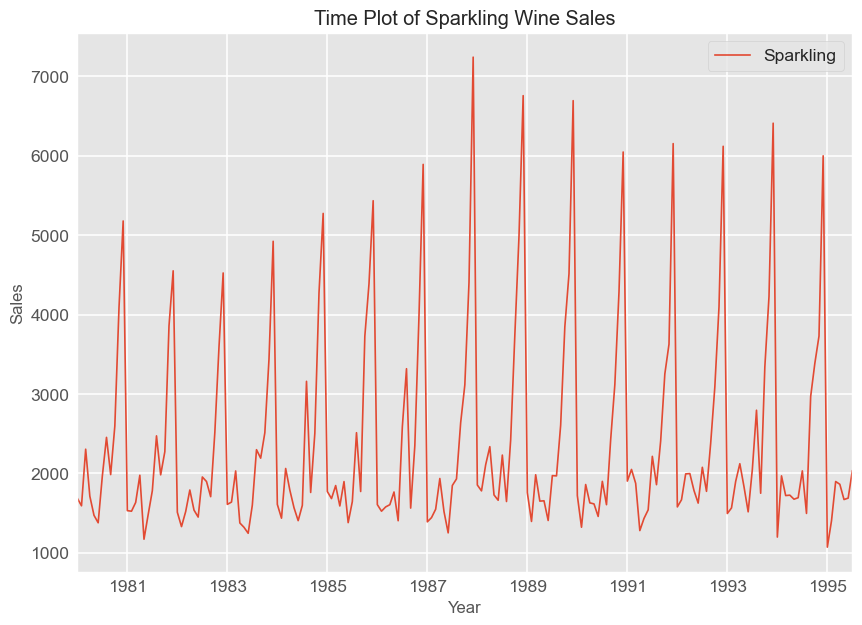

In [5]:
spark_df.plot(title="Time Plot of Sparkling Wine Sales",
              xlabel="Year",
              ylabel="Sales",
              figsize=(10, 7));
plt.savefig("images/Figure1.svg", bbox_inches="tight");

## 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

### Distribution of Sales data

In [6]:
spark_df.describe().T

count         mean         std     min     25%     50%     75%  \
Sparkling  187.0  2402.417112  1295.11154  1070.0  1605.0  1874.0  2549.0   

              max  
Sparkling  7242.0

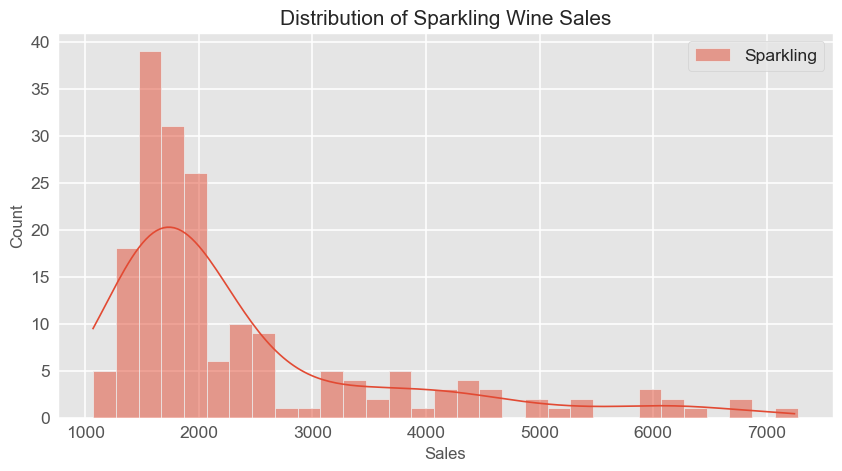

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=spark_df, binwidth=200, kde=True, ax=axs)
plt.xlabel("Sales")
plt.title("Distribution of Sparkling Wine Sales", size=15);
plt.savefig("images/Figure2.svg", bbox_inches="tight");

### Yearly Pointplot for Sales

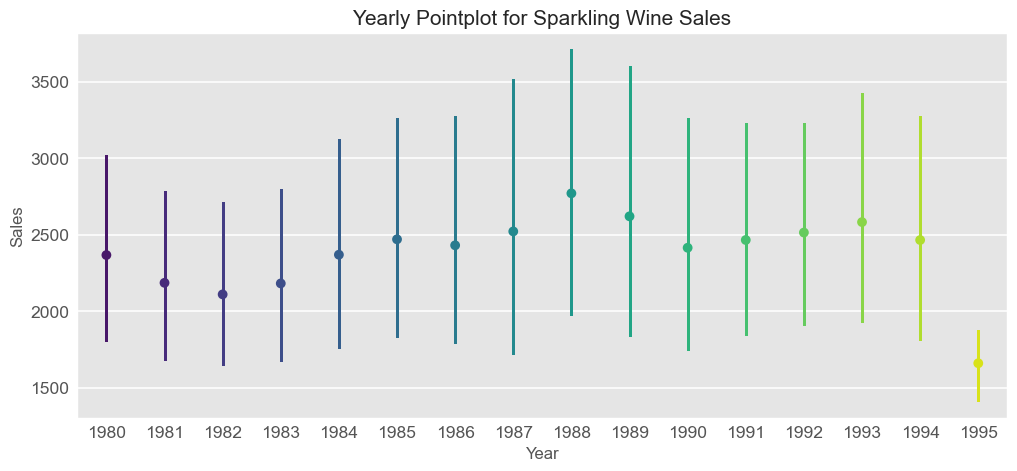

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
sns.pointplot(x=spark_df.index.year, y=spark_df.Sparkling, ax=axs, palette="viridis")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Yearly Pointplot for Sparkling Wine Sales", size=15);
plt.savefig("images/Figure3.svg", bbox_inches="tight");

### Monthly Sales Across Years

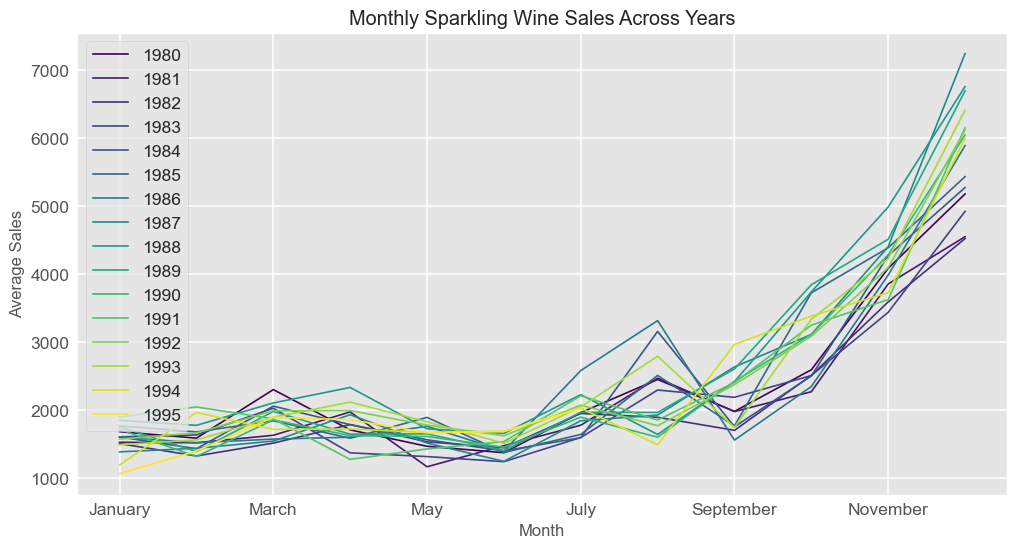

In [9]:
months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

monthly_sales_across_years = pd.pivot_table(
    spark_df,
    values='Sparkling',
    index=spark_df.index.year,
    columns=spark_df.index.month_name())

monthly_sales_across_years = monthly_sales_across_years.reindex(
    columns=months).T

monthly_sales_across_years.plot(
    ylabel="Average Sales",
    xlabel="Month",
    title="Monthly Sparkling Wine Sales Across Years",
    colormap='viridis',
    figsize=(12, 6))
plt.legend(loc='best');
plt.savefig("images/Figure4.svg", bbox_inches="tight");

### Decomposition

#### Additive Decomposition

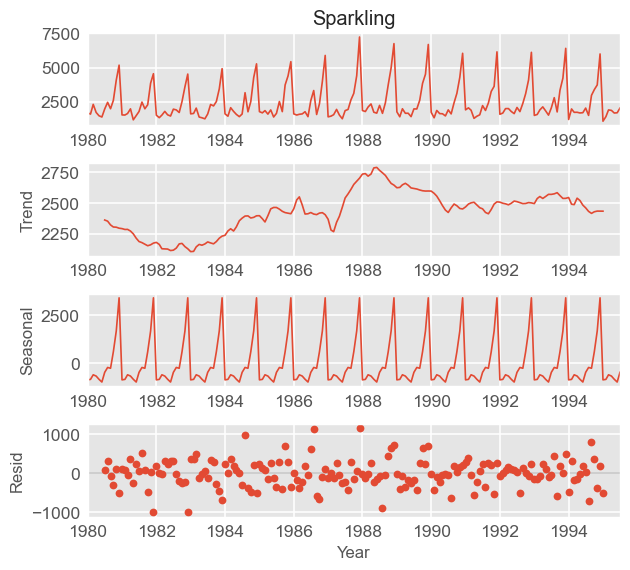

In [10]:
spark_decomposition = seasonal_decompose(spark_df["Sparkling"], model="add")
spark_decomposition.plot()
plt.xlabel("Year");
plt.savefig("images/Figure5_1.svg", bbox_inches="tight");

#### Multiplicative Decomposition

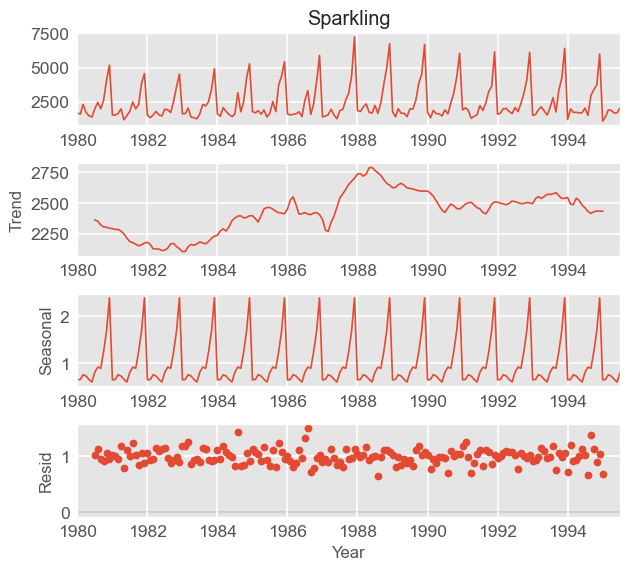

In [11]:
spark_decomposition = seasonal_decompose(spark_df["Sparkling"], model="multiplicative")
spark_decomposition.plot()
plt.xlabel("Year");
plt.savefig("images/Figure5_2.svg", bbox_inches="tight");

## 3. Split the data into training and test. The test data should start in 1991.

In [12]:
spark_train = spark_df.loc[spark_df.index.year < 1991]
spark_test = spark_df.loc[spark_df.index.year >= 1991]

In [13]:
print(f"Shape of the training data: {spark_train.shape}")
print(f"Shape of the testing data: {spark_test.shape}")

Shape of the training data: (132, 1)
Shape of the testing data: (55, 1)


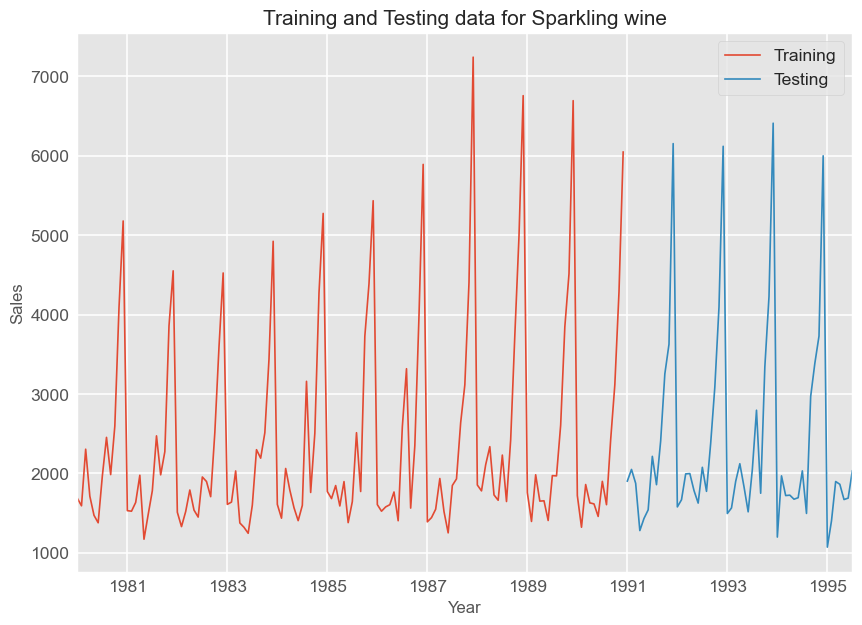

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_train.plot(ax=axs)
spark_test.plot(ax=axs)
axs.legend(["Training", "Testing"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Training and Testing data for Sparkling wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure6.svg", bbox_inches="tight");

## 4.  Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other additional models such as regression, naïve forecast models, simple average models, moving average models should also be built on the training data and check the performance on the test data using RMSE.

### Naive Forecast

In [15]:
spark_naive_train = spark_train.copy()
spark_naive_test = spark_test.copy()

In [16]:
spark_naive_test['Naive'] = np.asarray(spark_naive_train.iloc[len(spark_naive_train) - 1])[0]
spark_naive_test.head()

Sparkling  Naive
YearMonth                   
1991-01-01       1902   6047
1991-02-01       2049   6047
1991-03-01       1874   6047
1991-04-01       1279   6047
1991-05-01       1432   6047

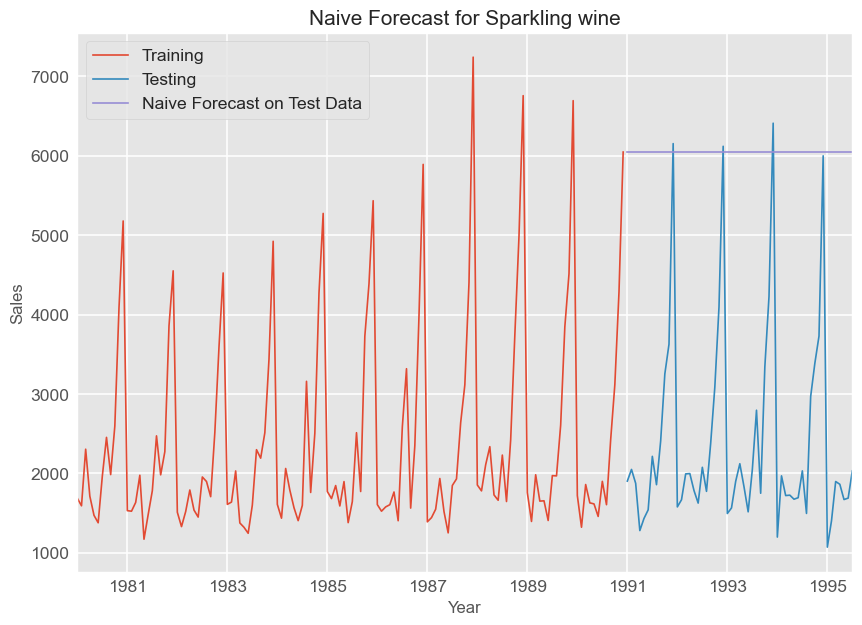

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_naive_train.plot(y="Sparkling", ax=axs)
spark_naive_test.plot(y="Sparkling", ax=axs)
spark_naive_test.plot(y="Naive", ax=axs)
axs.legend(["Training", "Testing", "Naive Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Naive Forecast for Sparkling wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure7.svg", bbox_inches="tight");

In [18]:
spark_naive_rmse = mean_squared_error(spark_naive_test["Sparkling"],
                                      spark_naive_test['Naive'],
                                      squared=False)
print(f"RMSE for Naive forecast model on Sparkling wine data: {spark_naive_rmse:.3f}")

RMSE for Naive forecast model on Sparkling wine data: 3864.279


In [19]:
spark_results_df = pd.DataFrame({'Test RMSE': [spark_naive_rmse]},
                                index=['Naive Model'])

### Linear Regression

In [20]:
spark_linreg_train = spark_train.copy()
spark_linreg_test = spark_test.copy()

In [21]:
spark_linreg_train["Time"] = [i + 1 for i in range(len(spark_linreg_train))]
spark_linreg_test["Time"] = [i + 133 for i in range(len(spark_linreg_test))]

In [22]:
spark_linreg_train.head()

Sparkling  Time
YearMonth                  
1980-01-01       1686     1
1980-02-01       1591     2
1980-03-01       2304     3
1980-04-01       1712     4
1980-05-01       1471     5

In [23]:
spark_linreg_test.head()

Sparkling  Time
YearMonth                  
1991-01-01       1902   133
1991-02-01       2049   134
1991-03-01       1874   135
1991-04-01       1279   136
1991-05-01       1432   137

In [24]:
spark_lr = LinearRegression()
spark_lr.fit(spark_linreg_train[["Time"]], spark_linreg_train["Sparkling"])

LinearRegression()

In [25]:
spark_linreg_test["RegOnTime"] = spark_lr.predict(spark_linreg_test[["Time"]])

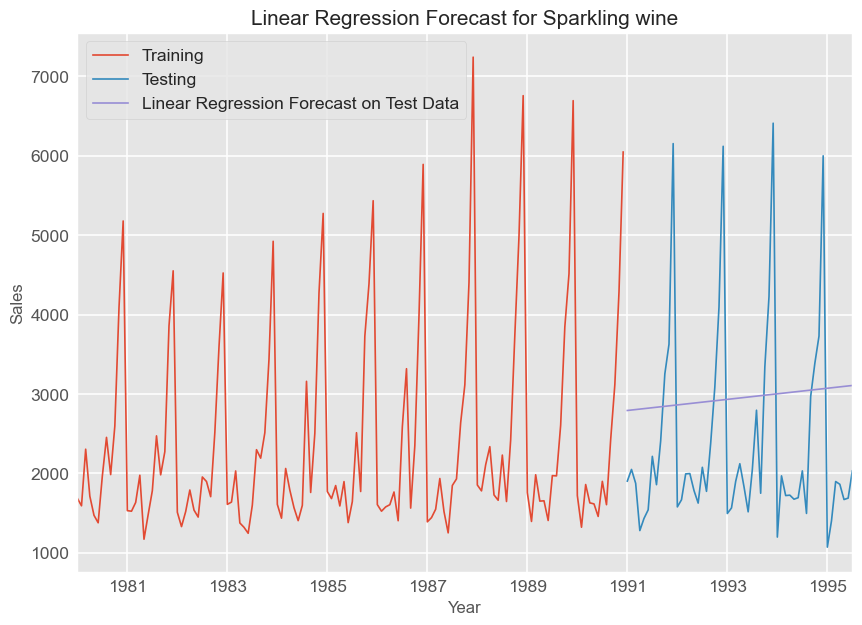

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_linreg_train.plot(y="Sparkling", ax=axs)
spark_linreg_test.plot(y="Sparkling", ax=axs)
spark_linreg_test.plot(y="RegOnTime", ax=axs)
axs.legend(["Training", "Testing", "Linear Regression Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Linear Regression Forecast for Sparkling wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure8.svg", bbox_inches="tight");

In [27]:
spark_linreg_rmse = mean_squared_error(spark_linreg_test["Sparkling"],
                                       spark_linreg_test['RegOnTime'],
                                       squared=False)
print(
    f"RMSE for Linear Regression forecast model on Sparkling wine data: {spark_linreg_rmse:.3f}"
)

RMSE for Linear Regression forecast model on Sparkling wine data: 1389.135


In [28]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({'Test RMSE': [spark_linreg_rmse]}, index=['Linear Regression'])
])

### Simple Average Model

In [29]:
spark_sam_train = spark_train.copy()
spark_sam_test = spark_test.copy()

In [30]:
spark_sam_test["Average Forecast"] = spark_sam_train["Sparkling"].mean()
spark_sam_test.head()

Sparkling  Average Forecast
YearMonth                              
1991-01-01       1902       2403.780303
1991-02-01       2049       2403.780303
1991-03-01       1874       2403.780303
1991-04-01       1279       2403.780303
1991-05-01       1432       2403.780303

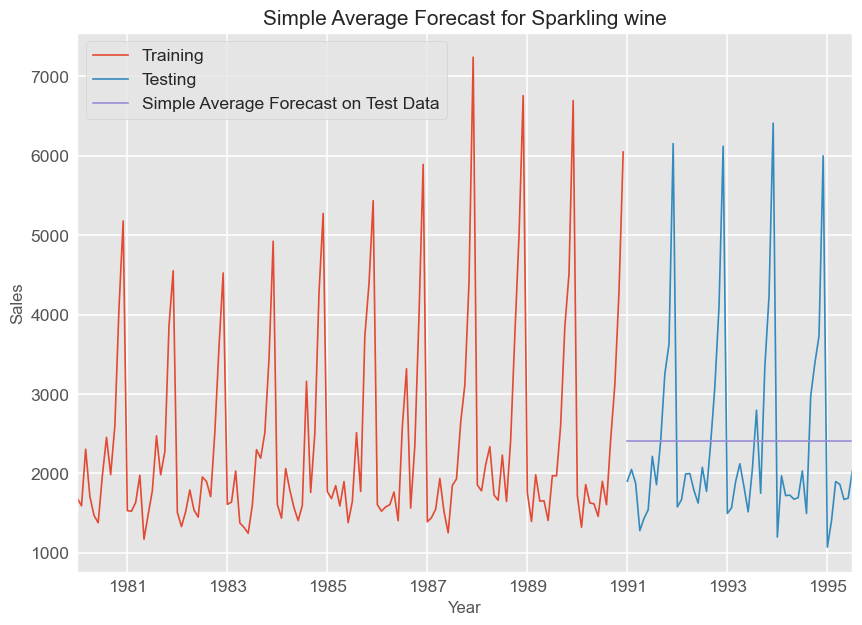

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_sam_train.plot(y="Sparkling", ax=axs)
spark_sam_test.plot(y="Sparkling", ax=axs)
spark_sam_test.plot(y="Average Forecast", ax=axs)
axs.legend(["Training", "Testing", "Simple Average Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Simple Average Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure9.svg", bbox_inches="tight");

In [32]:
spark_sam_rmse = mean_squared_error(
    spark_sam_test["Sparkling"], spark_sam_test["Average Forecast"], squared=False
)
print(
    f"RMSE for Simple Average forecast model on Sparkling wine data: {spark_sam_rmse:.3f}"
)

RMSE for Simple Average forecast model on Sparkling wine data: 1275.082


In [33]:
spark_results_df = pd.concat(
    [
        spark_results_df,
        pd.DataFrame({"Test RMSE": [spark_sam_rmse]}, index=["Simple Average"]),
    ]
)

### Moving Average (MA) Model

In [34]:
spark_ma_df = spark_df.copy()

In [35]:
spark_ma_df["2-MA"] = spark_ma_df["Sparkling"].rolling(2).mean()
spark_ma_df["4-MA"] = spark_ma_df["Sparkling"].rolling(4).mean()
spark_ma_df["6-MA"] = spark_ma_df["Sparkling"].rolling(6).mean()
spark_ma_df["8-MA"] = spark_ma_df["Sparkling"].rolling(8).mean()

spark_ma_df.head()

Sparkling    2-MA     4-MA  6-MA  8-MA
YearMonth                                         
1980-01-01       1686     NaN      NaN   NaN   NaN
1980-02-01       1591  1638.5      NaN   NaN   NaN
1980-03-01       2304  1947.5      NaN   NaN   NaN
1980-04-01       1712  2008.0  1823.25   NaN   NaN
1980-05-01       1471  1591.5  1769.50   NaN   NaN

In [36]:
spark_ma_train = spark_ma_df.loc[spark_ma_df.index.year < 1991]
spark_ma_test = spark_ma_df.loc[spark_ma_df.index.year >= 1991]

In [37]:
spark_ma_test.head()

Sparkling    2-MA     4-MA         6-MA      8-MA
YearMonth                                                    
1991-01-01       1902  3974.5  3837.75  3230.000000  2842.000
1991-02-01       2049  1975.5  3571.00  3304.000000  2916.000
1991-03-01       1874  1961.5  2968.00  3212.333333  2912.875
1991-04-01       1279  1576.5  1776.00  2906.166667  2872.125
1991-05-01       1432  1355.5  1658.50  2430.500000  2748.125

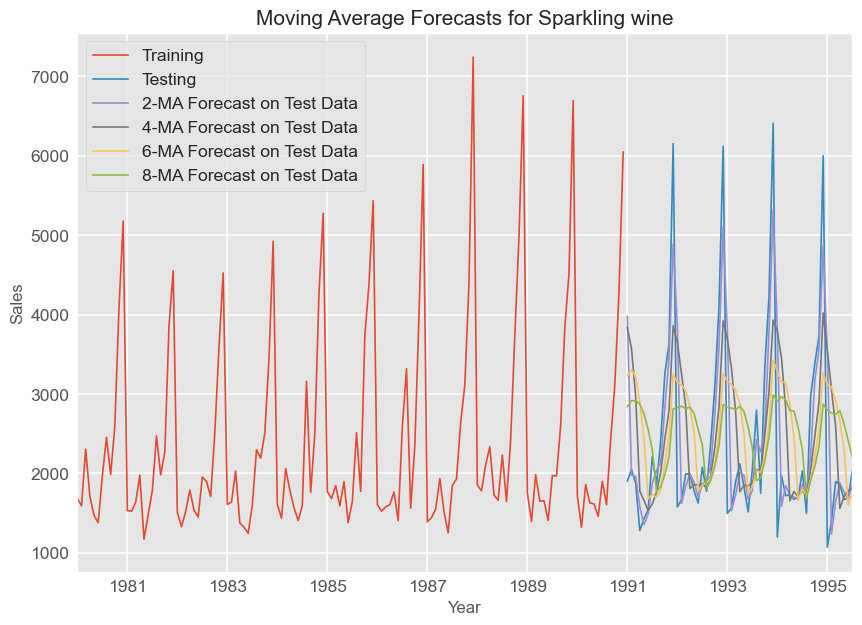

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_ma_train.plot(y="Sparkling", ax=axs)
spark_ma_test.plot(y="Sparkling", ax=axs)
spark_ma_test.plot(y="2-MA", ax=axs)
spark_ma_test.plot(y="4-MA", ax=axs)
spark_ma_test.plot(y="6-MA", ax=axs)
spark_ma_test.plot(y="8-MA", ax=axs)
axs.legend(
    [
        "Training",
        "Testing",
        "2-MA Forecast on Test Data",
        "4-MA Forecast on Test Data",
        "6-MA Forecast on Test Data",
        "8-MA Forecast on Test Data",
    ]
)
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Moving Average Forecasts for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure10.svg", bbox_inches="tight");

In [39]:
spark_2ma_rmse = mean_squared_error(spark_ma_test["Sparkling"], spark_ma_test["2-MA"], squared=False)
spark_4ma_rmse = mean_squared_error(spark_ma_test["Sparkling"], spark_ma_test["4-MA"], squared=False)
spark_6ma_rmse = mean_squared_error(spark_ma_test["Sparkling"], spark_ma_test["6-MA"], squared=False)
spark_8ma_rmse = mean_squared_error(spark_ma_test["Sparkling"], spark_ma_test["8-MA"], squared=False)

print(f"RMSE for 2-MA forecast model on Sparkling wine data: {spark_2ma_rmse:.3f}")
print(f"RMSE for 4-MA forecast model on Sparkling wine data: {spark_4ma_rmse:.3f}")
print(f"RMSE for 6-MA forecast model on Sparkling wine data: {spark_6ma_rmse:.3f}")
print(f"RMSE for 8-MA forecast model on Sparkling wine data: {spark_8ma_rmse:.3f}")

RMSE for 2-MA forecast model on Sparkling wine data: 813.401
RMSE for 4-MA forecast model on Sparkling wine data: 1156.590
RMSE for 6-MA forecast model on Sparkling wine data: 1283.927
RMSE for 8-MA forecast model on Sparkling wine data: 1342.568


In [40]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_2ma_rmse]},
                 index=["2 Point Moving Average"])
])

### Simple Exponential Smoothing (SES) Model

In [41]:
spark_SES_train = spark_train.copy()
spark_SES_test = spark_test.copy()

In [42]:
spark_SES_model = SimpleExpSmoothing(spark_SES_train.Sparkling,
                                     initialization_method='estimated')
spark_SES_autofit = spark_SES_model.fit(optimized=True, method='ls')

In [43]:
spark_SES_autofit.params

{'smoothing_level': 0.000,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2403.780,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [44]:
spark_SES_test["Predictions"] = spark_SES_autofit.forecast(steps=len(spark_SES_test))
spark_SES_test.head()

Sparkling  Predictions
YearMonth                         
1991-01-01       1902   2403.78031
1991-02-01       2049   2403.78031
1991-03-01       1874   2403.78031
1991-04-01       1279   2403.78031
1991-05-01       1432   2403.78031

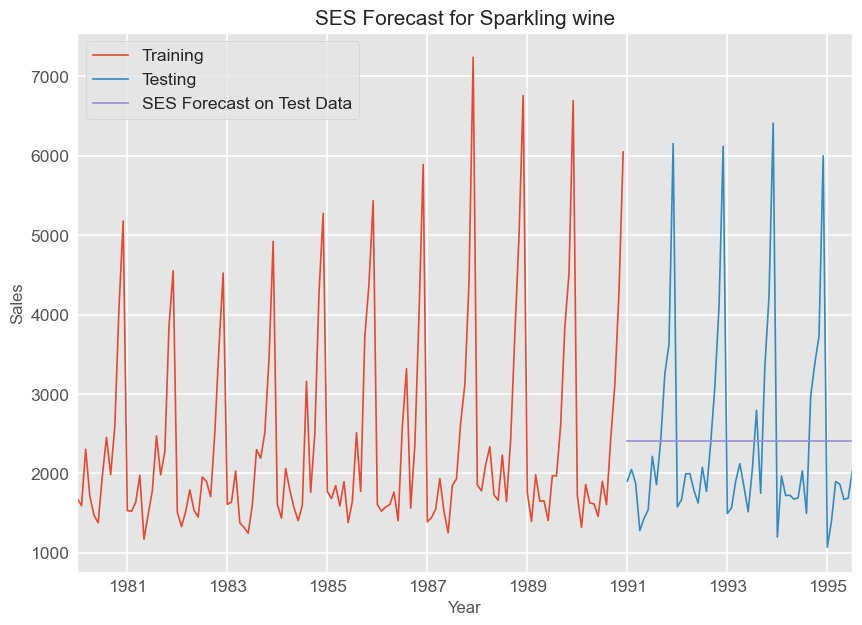

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_SES_train.plot(y="Sparkling", ax=axs)
spark_SES_test.plot(y="Sparkling", ax=axs)
spark_SES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "SES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("SES Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure11.svg", bbox_inches="tight");

In [46]:
spark_SES_rmse = mean_squared_error(spark_SES_test["Sparkling"],
                                    spark_SES_test["Predictions"],
                                    squared=False)
print(
    f"RMSE for SES forecast model on Sparkling wine data: {spark_SES_rmse:.3f}"
)

RMSE for SES forecast model on Sparkling wine data: 1275.082


In [47]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_SES_rmse]},
                 index=["Alpha=0, SES"])
])

### Holt (Double Exponential Smoothing) Model

In [48]:
spark_DES_train = spark_train.copy()
spark_DES_test = spark_test.copy()

In [49]:
spark_DES_model = Holt(spark_DES_train.Sparkling,
                       initialization_method='estimated')
spark_DES_autofit = spark_DES_model.fit(optimized=True, method='ls')

In [50]:
spark_DES_autofit.params

{'smoothing_level': 0.648,
 'smoothing_trend': 0.000,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1670.400,
 'initial_trend': 27.155,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [51]:
spark_DES_test["Predictions"] = spark_DES_autofit.forecast(steps=len(spark_DES_test))
spark_DES_test.head()

Sparkling  Predictions
YearMonth                         
1991-01-01       1902  5281.993752
1991-02-01       2049  5309.148538
1991-03-01       1874  5336.303323
1991-04-01       1279  5363.458108
1991-05-01       1432  5390.612894

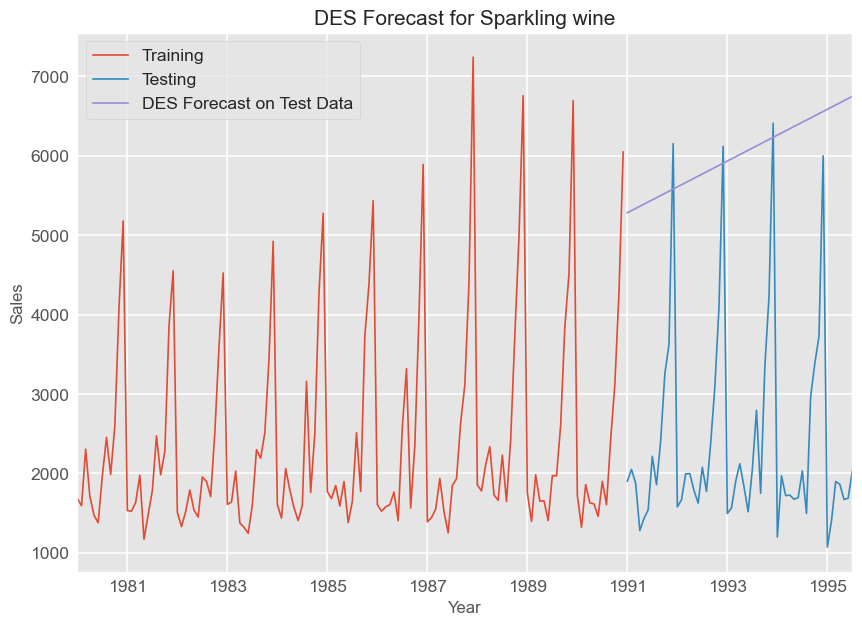

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_DES_train.plot(y="Sparkling", ax=axs)
spark_DES_test.plot(y="Sparkling", ax=axs)
spark_DES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "DES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("DES Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure12.svg", bbox_inches="tight");

In [53]:
spark_DES_rmse = mean_squared_error(spark_DES_test["Sparkling"],
                                    spark_DES_test["Predictions"],
                                    squared=False)
print(
    f"RMSE for DES forecast model on Sparkling wine data: {spark_DES_rmse:.3f}"
)

RMSE for DES forecast model on Sparkling wine data: 3854.073


In [54]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_DES_rmse]},
                 index=["Alpha=0.648, Beta=0, DES"])
])

### Holt-Winters (Triple Exponential Smoothing) Model

In [55]:
spark_TES_train = spark_train.copy()
spark_TES_test = spark_test.copy()

In [56]:
spark_TES_model = ExponentialSmoothing(spark_TES_train.Sparkling,
                                       trend='additive',
                                       seasonal='additive',
                                       initialization_method='estimated')
spark_TES_autofit = spark_TES_model.fit(optimized=True, method='ls')

In [57]:
spark_TES_autofit.params

{'smoothing_level': 0.082,
 'smoothing_trend': 0.000,
 'smoothing_seasonal': 0.474,
 'damping_trend': nan,
 'initial_level': 3325.132,
 'initial_trend': 0.288,
 'initial_seasons': array([-1663.164, -1738.205, -1271.782, -1485.487, -1845.598, -1850.294,
        -1368.608,  -843.923, -1293.058,  -727.119,   694.499,  1710.512]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [58]:
spark_TES_test["Predictions"] = spark_TES_autofit.forecast(steps=len(spark_TES_test))
spark_TES_test.head()

Sparkling  Predictions
YearMonth                         
1991-01-01       1902  1543.059974
1991-02-01       2049  1253.062589
1991-03-01       1874  1737.000913
1991-04-01       1279  1595.391100
1991-05-01       1432  1503.928504

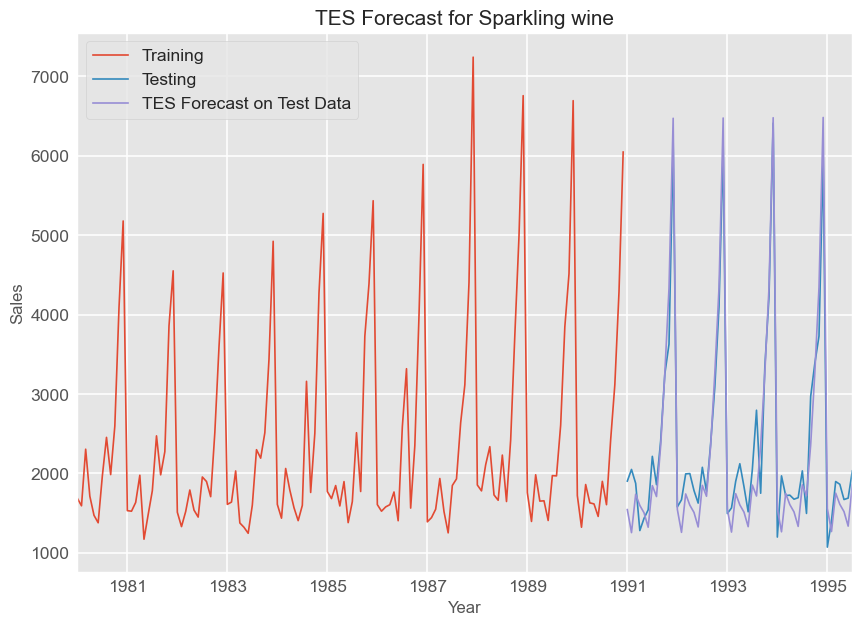

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_TES_train.plot(y="Sparkling", ax=axs)
spark_TES_test.plot(y="Sparkling", ax=axs)
spark_TES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "TES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("TES Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure13.svg", bbox_inches="tight");

In [60]:
spark_TES_rmse = mean_squared_error(spark_TES_test["Sparkling"],
                                    spark_TES_test["Predictions"],
                                    squared=False)
print(
    f"RMSE for TES forecast model on Sparkling wine data: {spark_TES_rmse:.3f}"
)

RMSE for TES forecast model on Sparkling wine data: 357.725


In [61]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_TES_rmse]},
                 index=["Alpha=0.08, Beta=0, Gamma=0.47, TES"])
])

## 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.

### Checking for Stationarity on Whole data

In [62]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression='ct')
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    dfoutput["Critical Value (5%)"] = dftest[4]['5%']
    print(dfoutput)

In [63]:
adf_test(spark_df)

Results of Dickey-Fuller Test:
Test Statistic         -1.798262
p-value                 0.705596
#Lags Used             12.000000
Critical Value (5%)    -3.436029
dtype: float64


### Differencing and Checking for Stationarity of Whole data

In [64]:
adf_test(spark_df.diff(12).diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic         -5.121008
p-value                 0.000123
#Lags Used             11.000000
Critical Value (5%)    -3.437946
dtype: float64


### Checking for Stationarity on Training data

In [65]:
adf_test(spark_train)

Results of Dickey-Fuller Test:
Test Statistic         -2.061798
p-value                 0.567411
#Lags Used             12.000000
Critical Value (5%)    -3.448049
dtype: float64


### Differencing and Checking for Stationarity of Training data

In [66]:
spark_train_diff = spark_train.diff(12).diff().dropna()

In [67]:
adf_test(spark_train_diff)

Results of Dickey-Fuller Test:
Test Statistic         -3.467900
p-value                 0.042955
#Lags Used             10.000000
Critical Value (5%)    -3.451953
dtype: float64


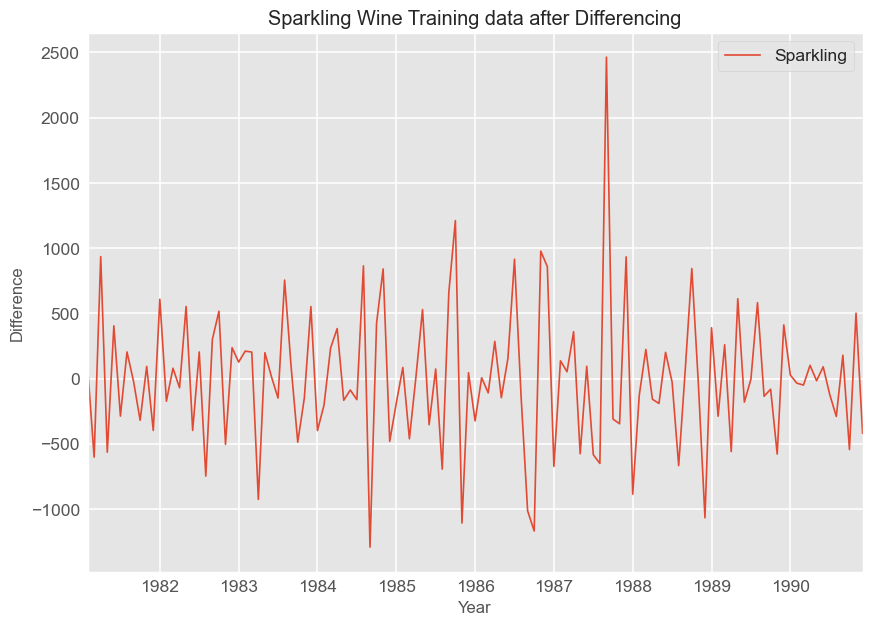

In [68]:
spark_train_diff.plot(title="Sparkling Wine Training data after Differencing",
                      xlabel="Year",
                      ylabel="Difference",
                      figsize=(10, 7));
plt.savefig("images/Figure14.svg", bbox_inches="tight");

## 6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

### Automated ARIMA(p, d, q) Model

In [69]:
import itertools

p = q = range(0, 4)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))
print('Some examples of the parameter combinations for the Model')
for i in range(0, 5):
    print(f'Model: {pdq[i]}')

Some examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)


In [89]:
spark_ARIMA_AIC = pd.DataFrame(columns=['parameters', 'AIC'])

for param in pdq:
    ARIMA_model = ARIMA(
        spark_train['Sparkling'].values,
        order=param,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(method='innovations_mle')

    print(f'ARIMA{param} - AIC:{ARIMA_model.aic}')

    spark_ARIMA_AIC = spark_ARIMA_AIC.append(
        {
            'parameters': param,
            'AIC': ARIMA_model.aic
        }, ignore_index=True)

ARIMA(0, 1, 0) - AIC:2251.359357868041
ARIMA(0, 1, 1) - AIC:2230.1660121634623
ARIMA(0, 1, 2) - AIC:2183.9967613316476
ARIMA(0, 1, 3) - AIC:2168.1459873649706
ARIMA(1, 1, 0) - AIC:2250.3221487159562
ARIMA(1, 1, 1) - AIC:2202.37720526913
ARIMA(1, 1, 2) - AIC:2184.7331979505507
ARIMA(1, 1, 3) - AIC:2169.743349486463
ARIMA(2, 1, 0) - AIC:2227.3158856073615
ARIMA(2, 1, 1) - AIC:2199.8818952065194
ARIMA(2, 1, 2) - AIC:2165.827386782632
ARIMA(2, 1, 3) - AIC:2163.6544106011056
ARIMA(3, 1, 0) - AIC:2208.4324622415597
ARIMA(3, 1, 1) - AIC:2185.3863075740437
ARIMA(3, 1, 2) - AIC:2181.9480628527886
ARIMA(3, 1, 3) - AIC:2181.6016121029193


In [90]:
spark_ARIMA_AIC.sort_values(by='AIC', ascending=True).head()

parameters          AIC
11  (2, 1, 3)  2163.654411
10  (2, 1, 2)  2165.827387
3   (0, 1, 3)  2168.145987
7   (1, 1, 3)  2169.743349
15  (3, 1, 3)  2181.601612

In [70]:
spark_auto_ARIMA = ARIMA(
    spark_train['Sparkling'],
    order=(2, 1, 3),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

spark_results_auto_ARIMA = spark_auto_ARIMA.fit(method='innovations_mle')

print(spark_results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1075.827
Date:                Sun, 25 Sep 2022   AIC                           2163.654
Time:                        17:12:49   BIC                           2180.720
Sample:                    01-01-1980   HQIC                          2170.588
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8475      0.120     -7.083      0.000      -1.082      -0.613
ar.L2         -0.4809      0.110     -4.372      0.000      -0.696      -0.265
ma.L1          0.3505      0.062      5.640      0.0

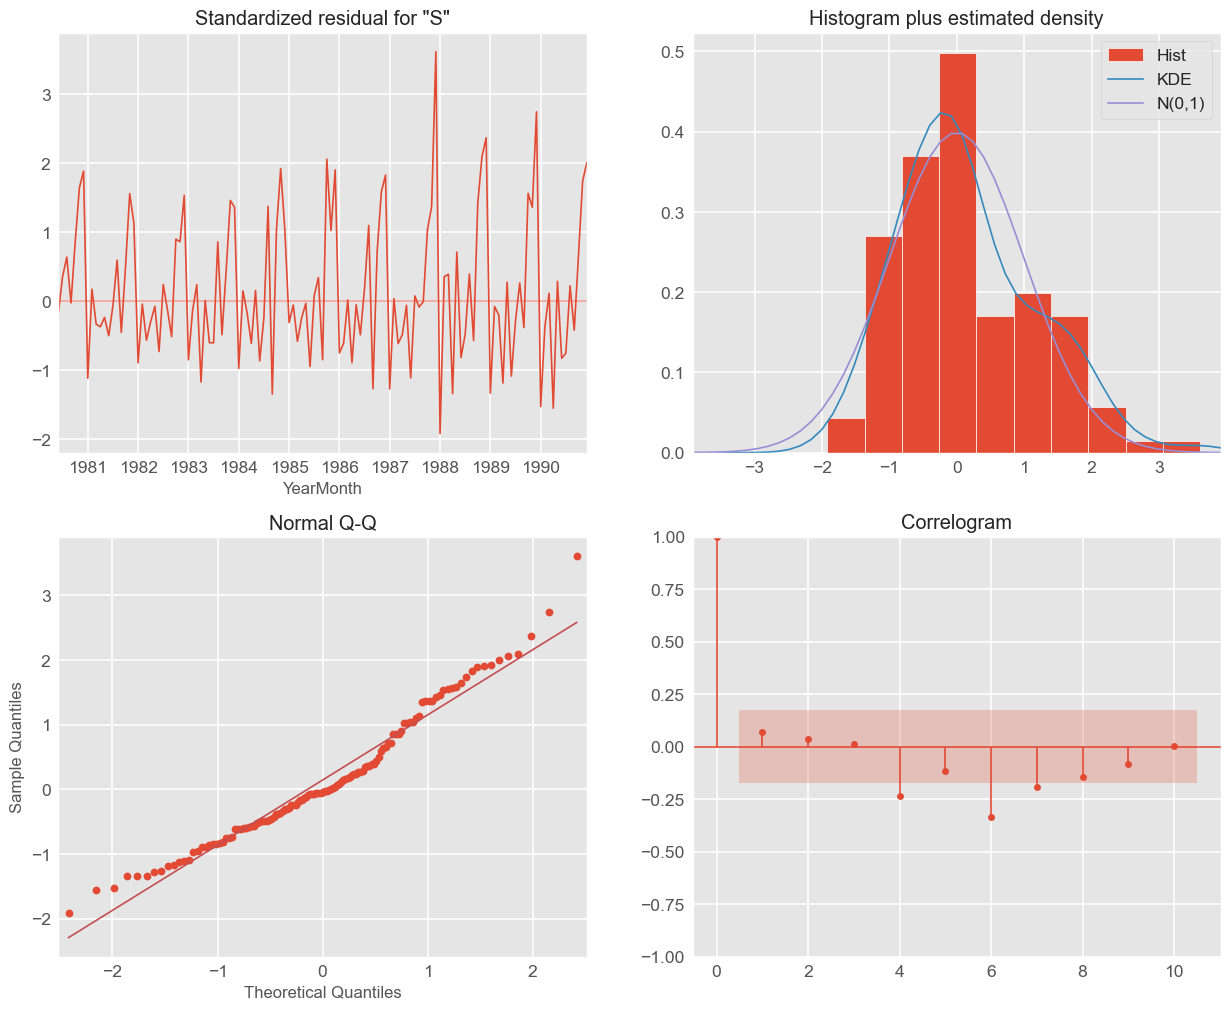

In [71]:
spark_results_auto_ARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure15.svg", bbox_inches="tight");

In [72]:
spark_predicted_auto_ARIMA = spark_results_auto_ARIMA.forecast(
    steps=len(spark_test))

In [73]:
spark_auto_ARIMA_rmse = mean_squared_error(spark_test["Sparkling"],
                                           spark_predicted_auto_ARIMA,
                                           squared=False)
print(
    f"RMSE for Auto ARIMA forecast model on Sparkling wine data: {spark_auto_ARIMA_rmse:.3f}"
)

RMSE for Auto ARIMA forecast model on Sparkling wine data: 1294.096


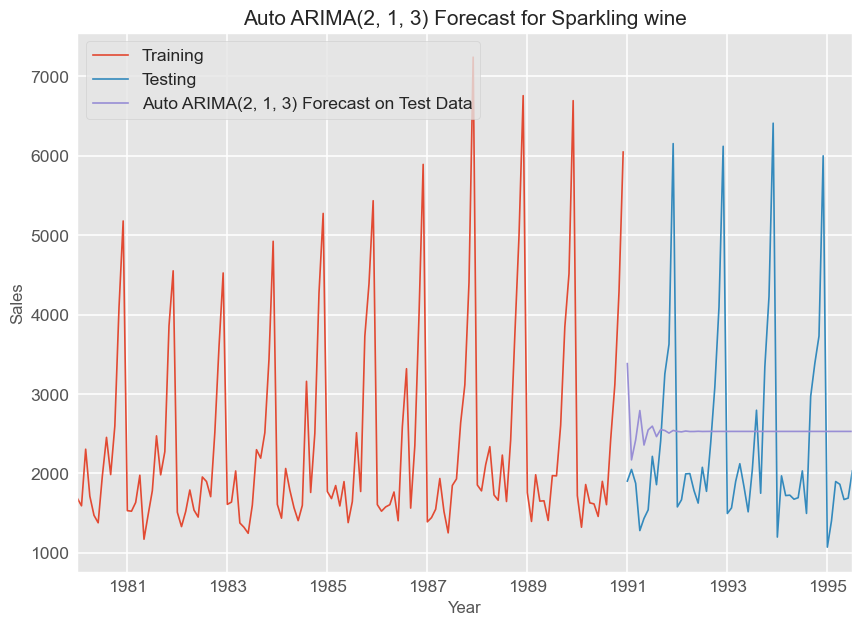

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_train.plot(y="Sparkling", ax=axs)
spark_test.plot(y="Sparkling", ax=axs)
spark_predicted_auto_ARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Auto ARIMA(2, 1, 3) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Auto ARIMA(2, 1, 3) Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure16.svg", bbox_inches="tight");

In [75]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_auto_ARIMA_rmse]},
                 index=["Auto ARIMA(2, 1, 3)"])
])

### Automated SARIMA(p, d, q)(P, D, Q, F) Model

In [76]:
p = q = range(0, 4)
d = D = range(1, 2)
pdq = list(itertools.product(p, d, q))
PDQF = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Some examples of the parameter combinations for the Model')
for i in range(0, 5):
    print('Model: {}{}'.format(pdq[i], PDQF[i]))

Some examples of the parameter combinations for the Model
Model: (0, 1, 0)(0, 1, 0, 12)
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 2)(0, 1, 2, 12)
Model: (0, 1, 3)(0, 1, 3, 12)
Model: (1, 1, 0)(1, 1, 0, 12)


In [98]:
spark_SARIMA_AIC = pd.DataFrame(columns=['parameters', 'seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in PDQF:
        SARIMA_model = sm.tsa.statespace.SARIMAX(
            spark_train['Sparkling'],
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(method='nm', disp=0)

        print(f'SARIMA{param}{param_seasonal} - AIC:{SARIMA_model.aic}')

        spark_SARIMA_AIC = spark_SARIMA_AIC.append(
            {
                'parameters': param,
                'seasonal': param_seasonal,
                'AIC': SARIMA_model.aic
            },
            ignore_index=True)

In [97]:
spark_SARIMA_AIC.sort_values(by='AIC', ascending=True).iloc[11:16]

parameters       seasonal          AIC
252  (3, 1, 3)  (3, 1, 0, 12)  1218.046909
237  (3, 1, 2)  (3, 1, 1, 12)  1219.530782
253  (3, 1, 3)  (3, 1, 1, 12)  1220.153057
220  (3, 1, 1)  (3, 1, 0, 12)  1222.177229
221  (3, 1, 1)  (3, 1, 1, 12)  1224.649211

In [77]:
spark_auto_SARIMA = sm.tsa.statespace.SARIMAX(
    spark_train['Sparkling'],
    order=(3, 1, 3),
    seasonal_order=(3, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

spark_results_auto_SARIMA = spark_auto_SARIMA.fit(method='nm', disp=False, maxiter=10000)

print(spark_results_auto_SARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Sparkling   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(3, 1, [], 12)   Log Likelihood                -596.483
Date:                             Sun, 25 Sep 2022   AIC                           1212.966
Time:                                     17:13:39   BIC                           1236.786
Sample:                                 01-01-1980   HQIC                          1222.516
                                      - 12-01-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6134      0.140    -11.524      0.000      -1.888      -1.339
ar.L2         -0.6101      

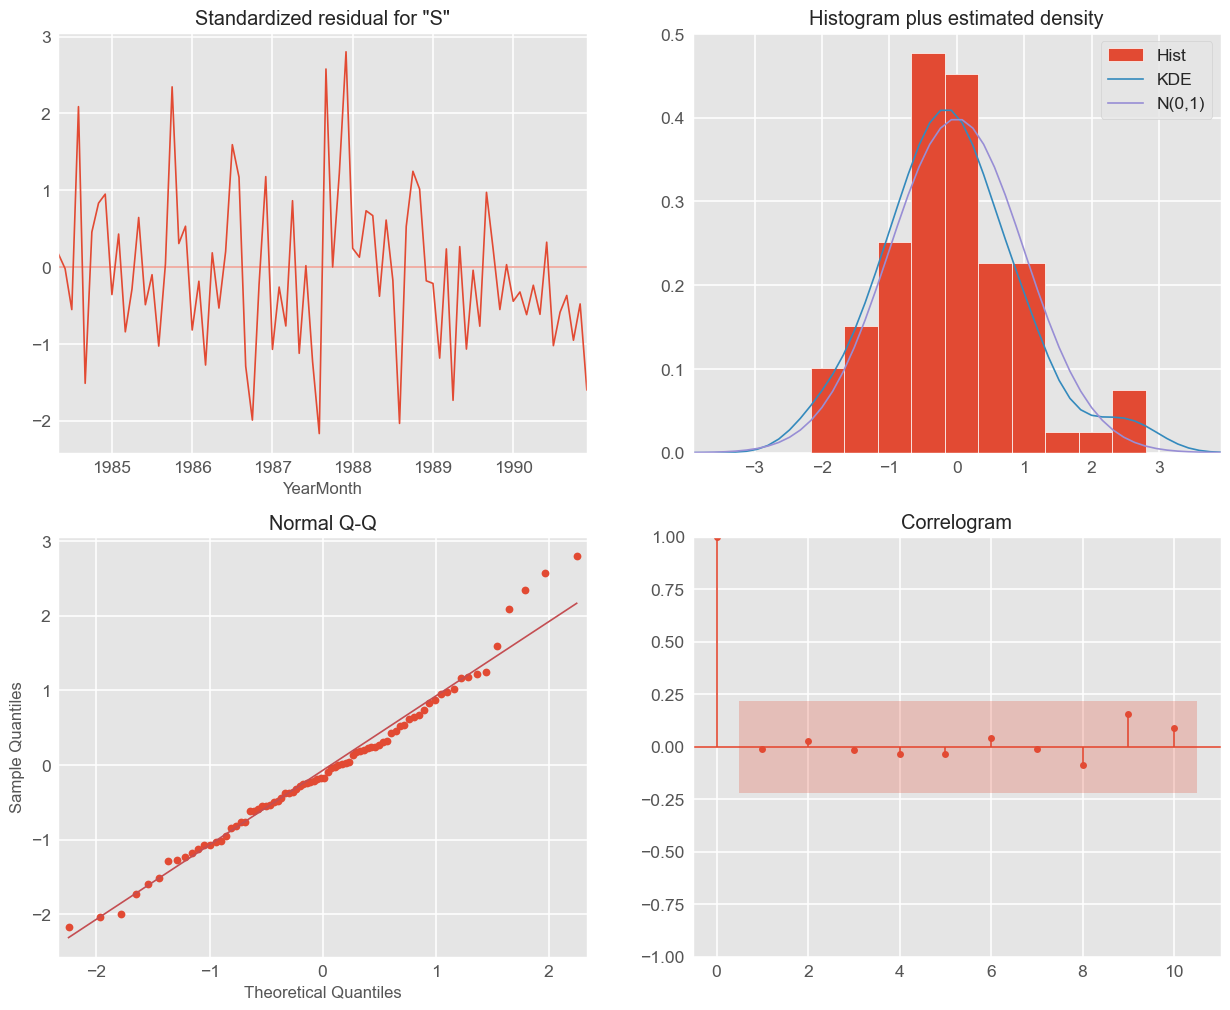

In [78]:
spark_results_auto_SARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure17.svg", bbox_inches="tight");

In [79]:
spark_predicted_auto_SARIMA = spark_results_auto_SARIMA.forecast(
    steps=len(spark_test))

In [80]:
spark_auto_SARIMA_rmse = mean_squared_error(spark_test.Sparkling,
                                            spark_predicted_auto_SARIMA,
                                            squared=False)
print(
    f"RMSE for Auto SARIMA forecast model on Sparkling wine data: {spark_auto_SARIMA_rmse:.3f}"
)

RMSE for Auto SARIMA forecast model on Sparkling wine data: 329.782


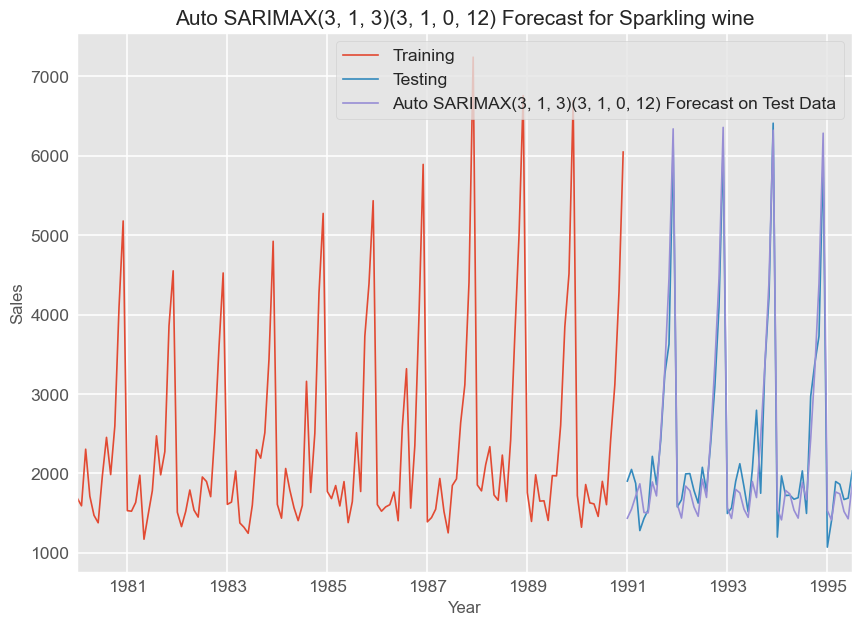

In [81]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_train.plot(y="Sparkling", ax=axs)
spark_test.plot(y="Sparkling", ax=axs)
spark_predicted_auto_SARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Auto SARIMAX(3, 1, 3)(3, 1, 0, 12) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Auto SARIMAX(3, 1, 3)(3, 1, 0, 12) Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure18.svg", bbox_inches="tight");

In [82]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_auto_SARIMA_rmse]},
                 index=["Auto SARIMAX(3, 1, 3)(3, 1, 0, 12)"])
])

## 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

### PACF Plot

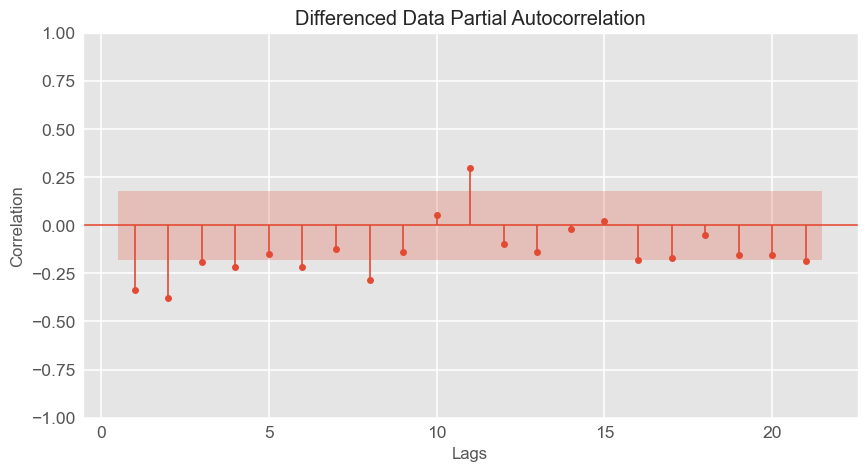

In [83]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_pacf(spark_train_diff,
          zero=False,
          title='Differenced Data Partial Autocorrelation',
          ax=axs)
axs.set_xlabel("Lags")
axs.set_ylabel("Correlation");
plt.savefig("images/Figure19.svg", bbox_inches="tight");

### ACF Plot

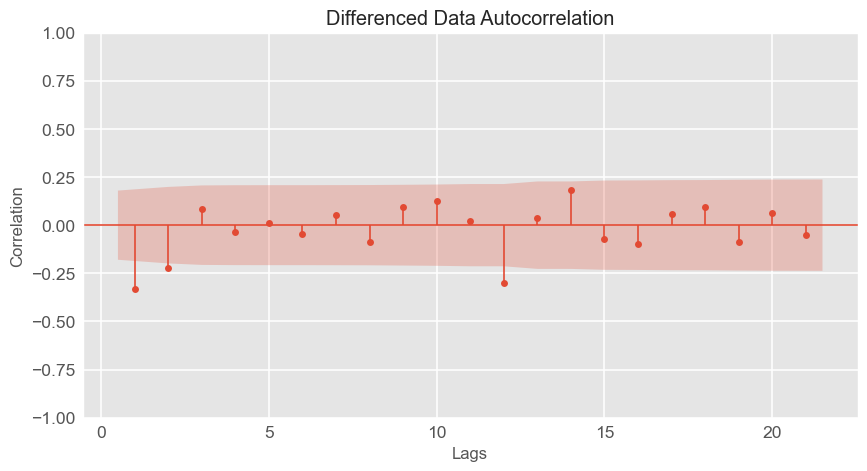

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_acf(spark_train_diff,
         zero=False,
         title='Differenced Data Autocorrelation',
         ax=axs)
axs.set_xlabel("Lags")
axs.set_ylabel("Correlation");
plt.savefig("images/Figure20.svg", bbox_inches="tight");

### Manual ARIMA(p, d, q) Model

In [85]:
spark_manual_ARIMA = ARIMA(
    spark_train['Sparkling'],
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

spark_results_manual_ARIMA = spark_manual_ARIMA.fit(method='innovations_mle')

print(spark_results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1077.914
Date:                Sun, 25 Sep 2022   AIC                           2165.827
Time:                        17:14:09   BIC                           2180.088
Sample:                    01-01-1980   HQIC                          2171.621
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3098      0.045     28.859      0.000       1.221       1.399
ar.L2         -0.5559      0.072     -7.674      0.000      -0.698      -0.414
ma.L1         -1.9910      0.110    -18.060      0.0

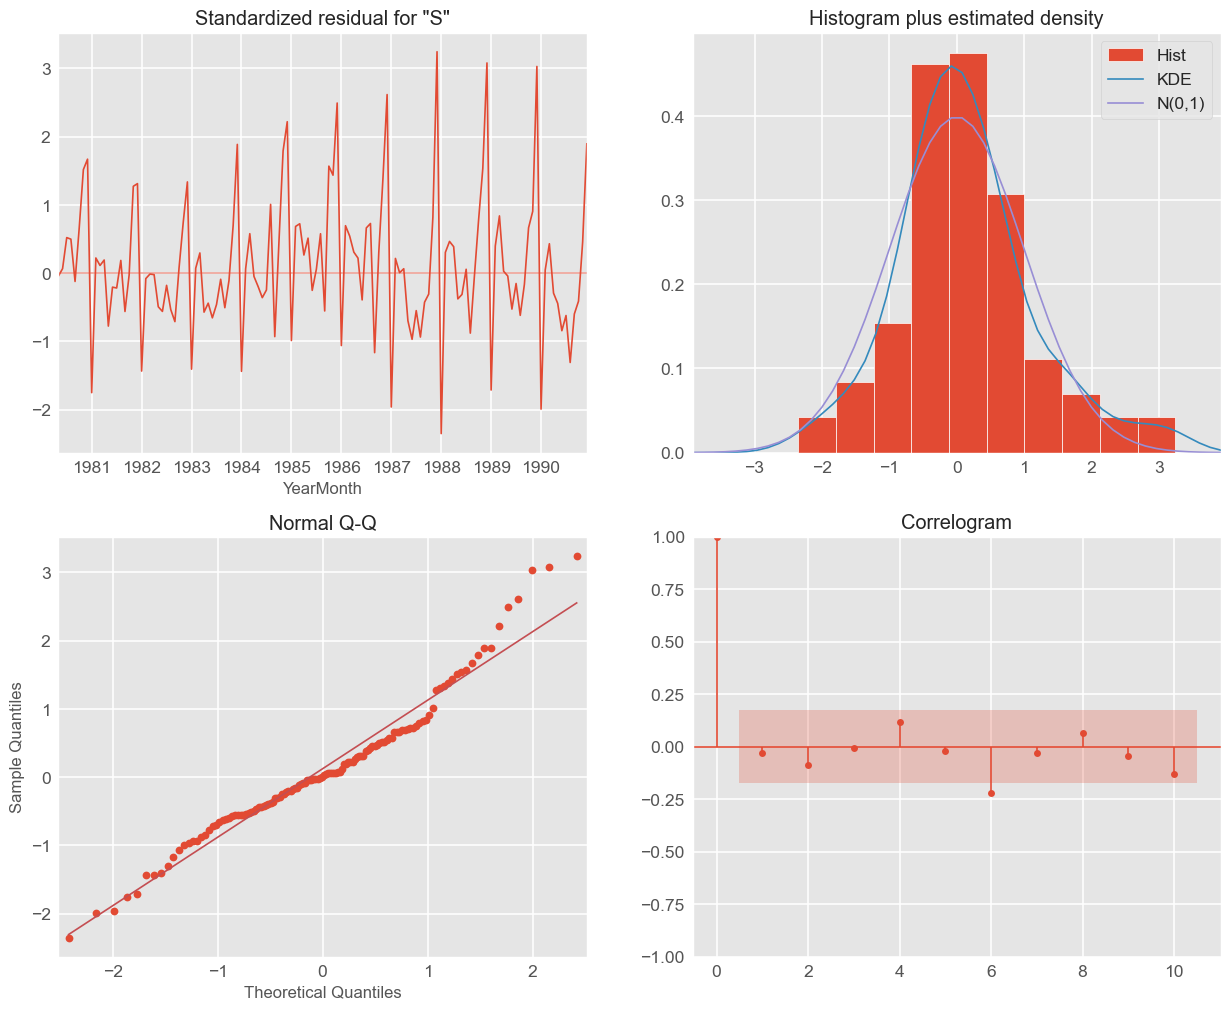

In [86]:
spark_results_manual_ARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure21.svg", bbox_inches="tight");

In [87]:
spark_predicted_manual_ARIMA = spark_results_manual_ARIMA.forecast(
    steps=len(spark_test))

In [88]:
spark_manual_ARIMA_rmse = mean_squared_error(spark_test["Sparkling"],
                                             spark_predicted_manual_ARIMA,
                                             squared=False)
print(
    f"RMSE for Manual ARIMA forecast model on Sparkling wine data: {spark_manual_ARIMA_rmse:.3f}"
)

RMSE for Manual ARIMA forecast model on Sparkling wine data: 1300.135


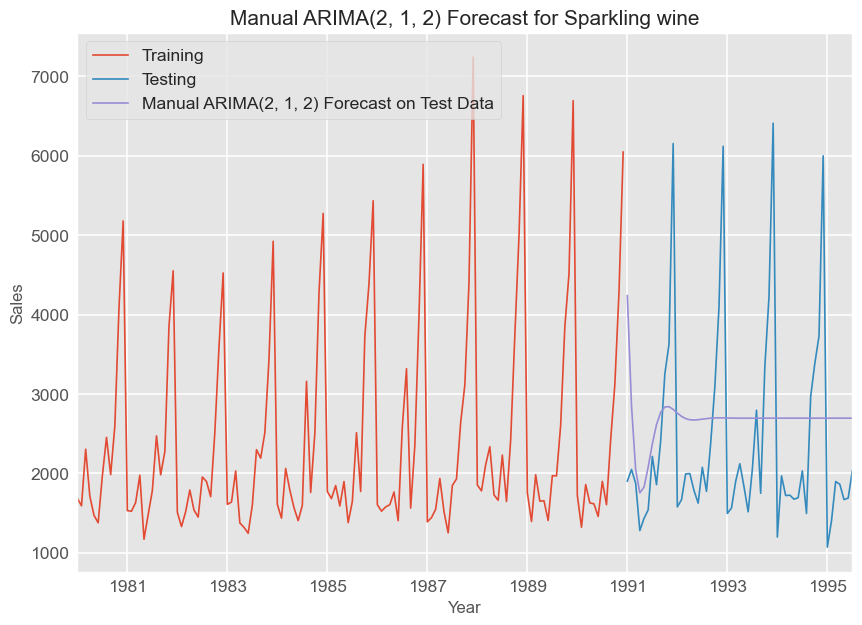

In [89]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_train.plot(y="Sparkling", ax=axs)
spark_test.plot(y="Sparkling", ax=axs)
spark_predicted_manual_ARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Manual ARIMA(2, 1, 2) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Manual ARIMA(2, 1, 2) Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure22.svg", bbox_inches="tight");

In [90]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_manual_ARIMA_rmse]},
                 index=["Manual ARIMA(2, 1, 2)"])
])

### Manual SARIMA(p, d, q)(P, D, Q, F) Model

In [91]:
spark_manual_SARIMA = sm.tsa.statespace.SARIMAX(
    spark_train['Sparkling'],
    order=(2, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

spark_results_manual_SARIMA = spark_manual_SARIMA.fit(method='nm', disp=False, maxiter=10000)

print(spark_results_manual_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -772.473
Date:                              Sun, 25 Sep 2022   AIC                           1556.947
Time:                                      17:14:27   BIC                           1572.813
Sample:                                  01-01-1980   HQIC                          1563.375
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5504      0.295     -1.868      0.062      -1.128       0.027
ar.L2         -0.01

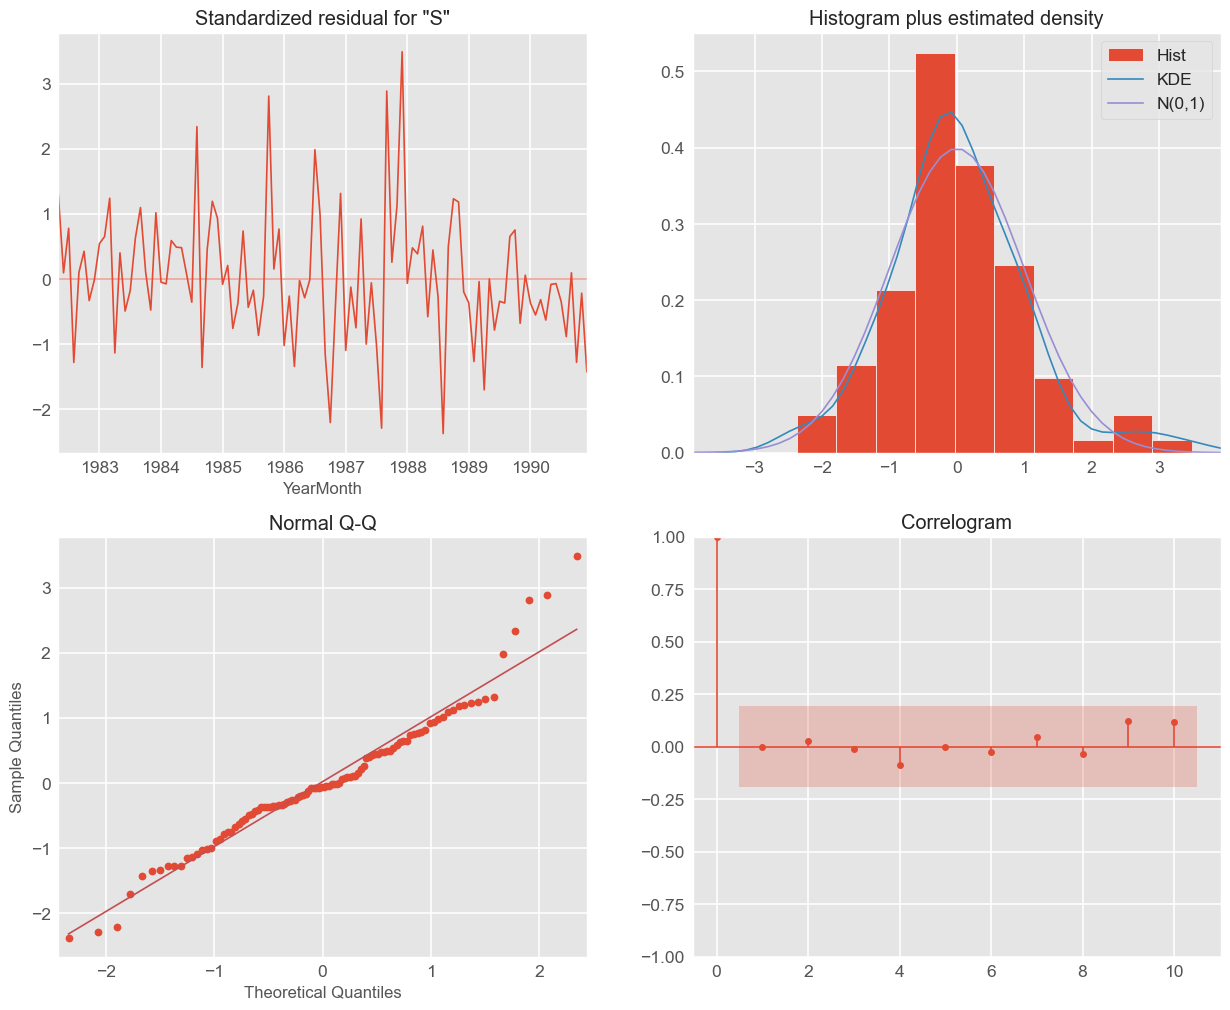

In [92]:
spark_results_manual_SARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure23.svg", bbox_inches="tight");

In [93]:
spark_predicted_manual_SARIMA = spark_results_manual_SARIMA.forecast(
    steps=len(spark_test))

In [94]:
spark_manual_SARIMA_rmse = mean_squared_error(spark_test.Sparkling,
                                              spark_predicted_manual_SARIMA,
                                              squared=False)
print(
    f"RMSE for Manual SARIMA forecast model on Sparkling wine data: {spark_manual_SARIMA_rmse:.3f}"
)

RMSE for Manual SARIMA forecast model on Sparkling wine data: 452.981


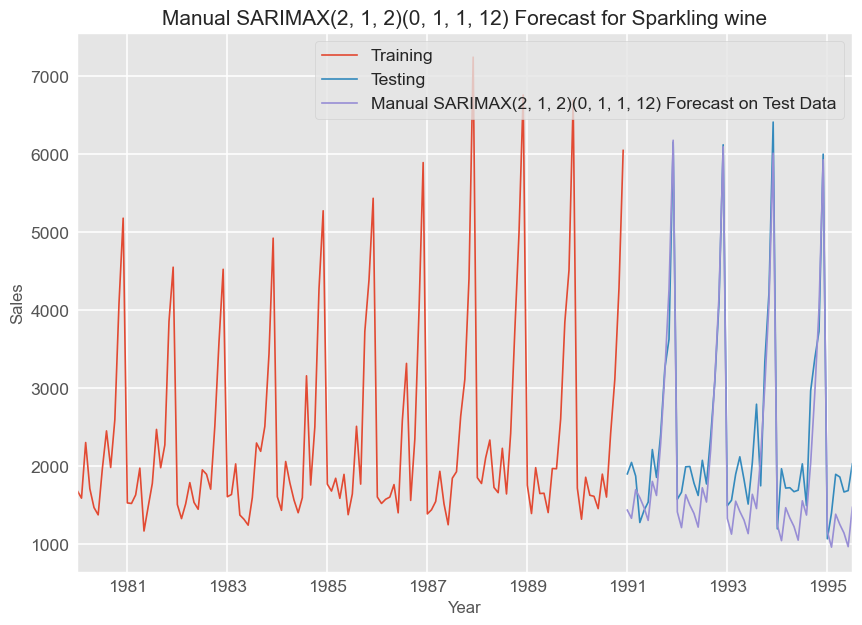

In [95]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
spark_train.plot(y="Sparkling", ax=axs)
spark_test.plot(y="Sparkling", ax=axs)
spark_predicted_manual_SARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Manual SARIMAX(2, 1, 2)(0, 1, 1, 12) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Manual SARIMAX(2, 1, 2)(0, 1, 1, 12) Forecast for Sparkling wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure24.svg", bbox_inches="tight");

In [96]:
spark_results_df = pd.concat([
    spark_results_df,
    pd.DataFrame({"Test RMSE": [spark_manual_SARIMA_rmse]},
                 index=["Manual SARIMAX(2, 1, 2)(0, 1, 1, 12)"])
])

## 8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [97]:
spark_results_df.sort_values(by='Test RMSE', ascending=True)

Test RMSE
Auto SARIMAX(3, 1, 3)(3, 1, 0, 12)     329.781694
Alpha=0.08, Beta=0, Gamma=0.47, TES    357.725412
Manual SARIMAX(2, 1, 2)(0, 1, 1, 12)   452.981437
2 Point Moving Average                 813.400684
Simple Average                        1275.081804
Alpha=0, SES                          1275.081804
Auto ARIMA(2, 1, 3)                   1294.095597
Manual ARIMA(2, 1, 2)                 1300.134815
Linear Regression                     1389.135175
Alpha=0.648, Beta=0, DES              3854.073054
Naive Model                           3864.279352

## 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

In [98]:
spark_optimum_full = sm.tsa.statespace.SARIMAX(
    spark_df['Sparkling'],
    order=(3, 1, 3),
    seasonal_order=(3, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

spark_results_full = spark_optimum_full.fit(method='nm',
                                            disp=False,
                                            maxiter=10000)

print(spark_results_full.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Sparkling   No. Observations:                  187
Model:             SARIMAX(3, 1, 3)x(3, 1, [], 12)   Log Likelihood                -998.042
Date:                             Sun, 25 Sep 2022   AIC                           2016.083
Time:                                     17:15:28   BIC                           2045.136
Sample:                                 01-01-1980   HQIC                          2027.890
                                      - 07-01-1995                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0051      0.104     -9.705      0.000      -1.208      -0.802
ar.L2         -0.8249      

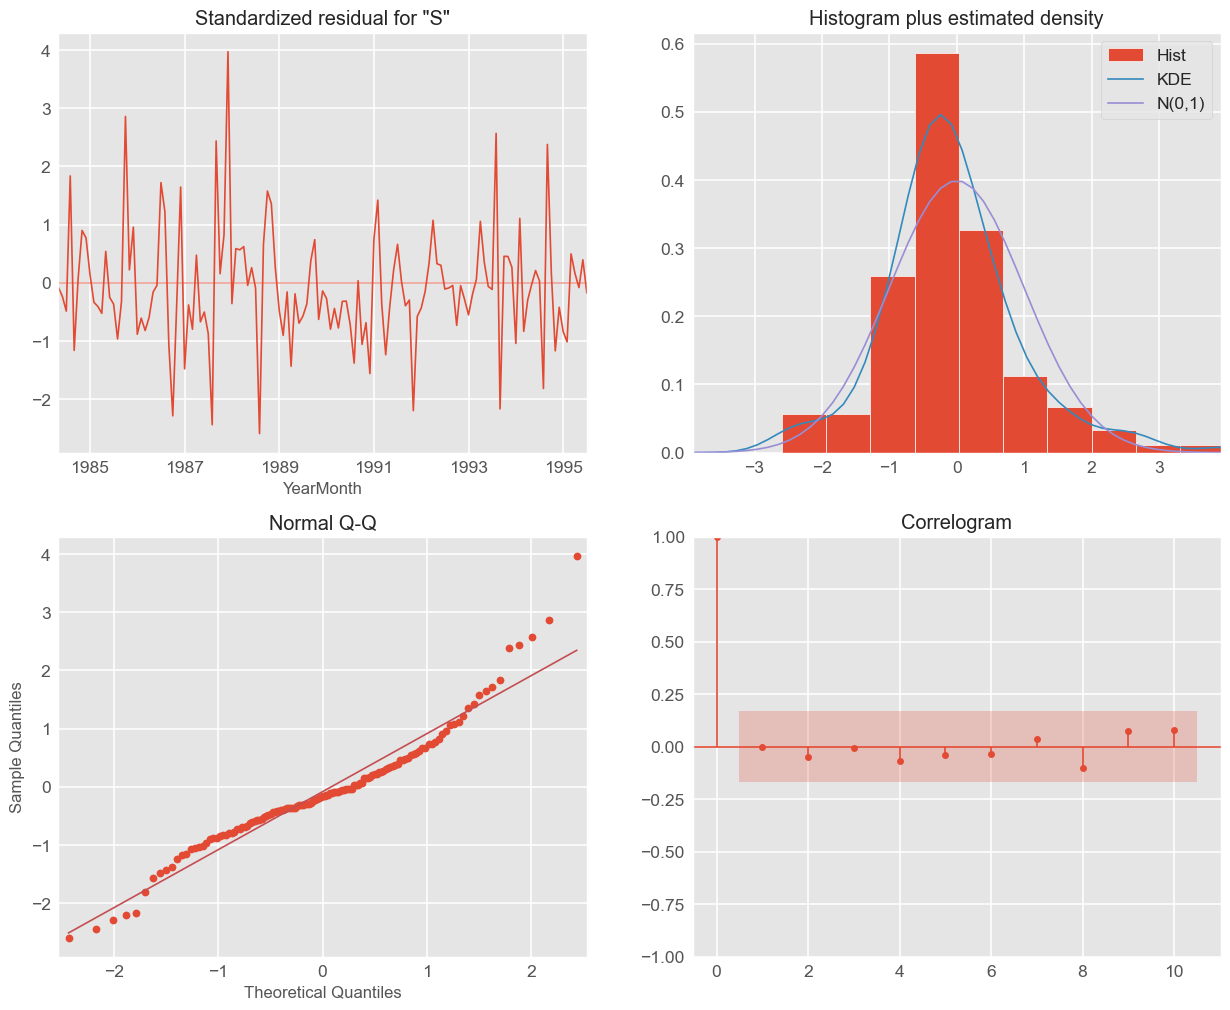

In [99]:
spark_results_full.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure25.svg", bbox_inches="tight");

In [100]:
spark_predicted_full = spark_results_full.get_forecast(steps=12)
spark_prediction_full = spark_predicted_full.summary_frame(alpha=0.05)
spark_prediction_full.head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-01  1930.776429  388.376124    1169.573214    2691.979645
1995-09-01  2399.745178  395.208990    1625.149791    3174.340565
1995-10-01  3332.333746  395.557877    2557.054555    4107.612938
1995-11-01  3870.549321  395.568805    3095.248710    4645.849932
1995-12-01  6090.893677  396.766230    5313.246155    6868.541198

In [101]:
spark_full_rmse = mean_squared_error(spark_df.Sparkling,
                                     spark_results_full.fittedvalues,
                                     squared=False)
print(
    f"RMSE for the final model on complete data: {spark_full_rmse:.3f}"
)

RMSE for the final model on complete data: 612.763


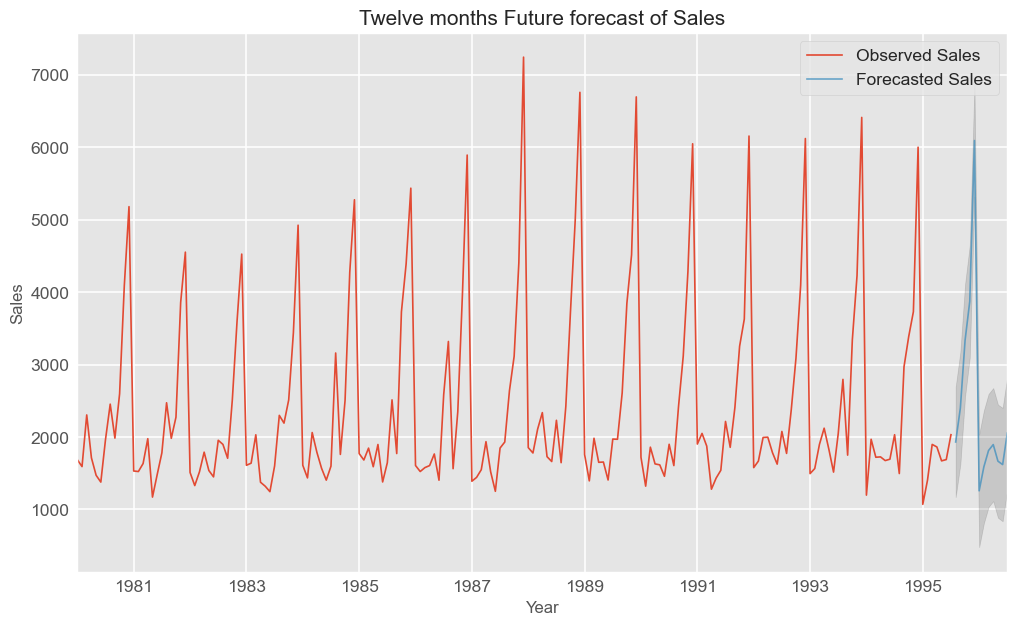

In [102]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
spark_df.plot(y="Sparkling", ax=axs)
spark_prediction_full['mean'].plot(ax=axs, alpha=0.7)
axs.fill_between(spark_prediction_full.index,
                 spark_prediction_full["mean_ci_lower"],
                 spark_prediction_full["mean_ci_upper"],
                 color='k',
                 alpha=0.15)
axs.legend(["Observed Sales", "Forecasted Sales"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Twelve months Future forecast of Sales",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure26.svg", bbox_inches="tight");

# Rose Wine Sales Data

## 1. Read the data as an appropriate Time Series data and plot the data.

### Sample of the Dataset.

In [103]:
rose_df = pd.read_csv("datasets/Rose.csv",
                      parse_dates=['YearMonth'],
                      index_col='YearMonth')
rose_df.index.freq = 'MS'
rose_df.head()

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

### Checking the types of variables in the dataset.

In [104]:
rose_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


### Imputing Missing Values

In [105]:
rose_df.interpolate(inplace=True)

In [106]:
rose_df.isnull().sum()

Rose    0
dtype: int64

### Time Plot of the Time Series

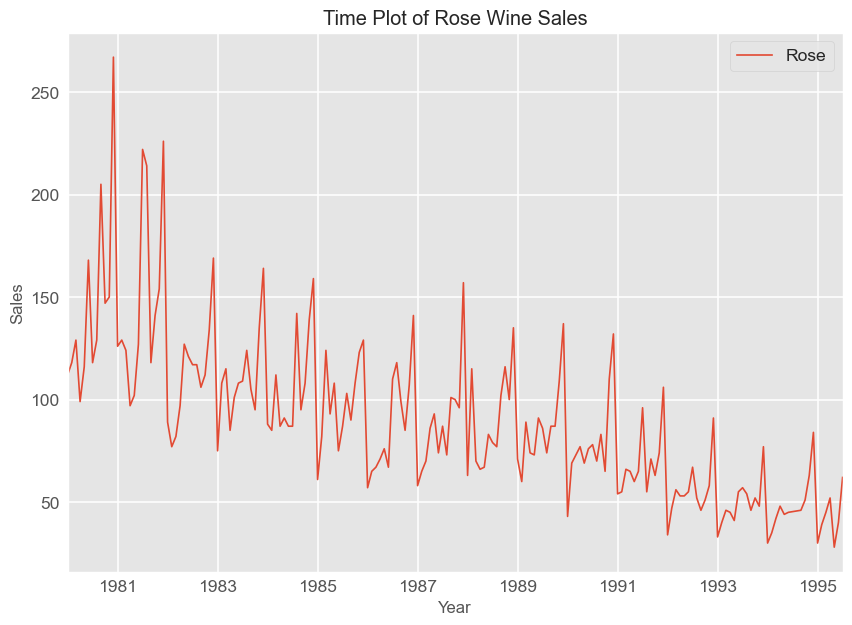

In [107]:
rose_df.plot(title="Time Plot of Rose Wine Sales",
             xlabel="Year",
             ylabel="Sales",
             figsize=(10, 7));
plt.savefig("images/Figure27.svg", bbox_inches="tight");

## 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

### Distribution of Sales data

In [108]:
rose_df.describe().T

count       mean        std   min   25%   50%    75%    max
Rose  187.0  89.914439  39.238325  28.0  62.5  85.0  111.0  267.0

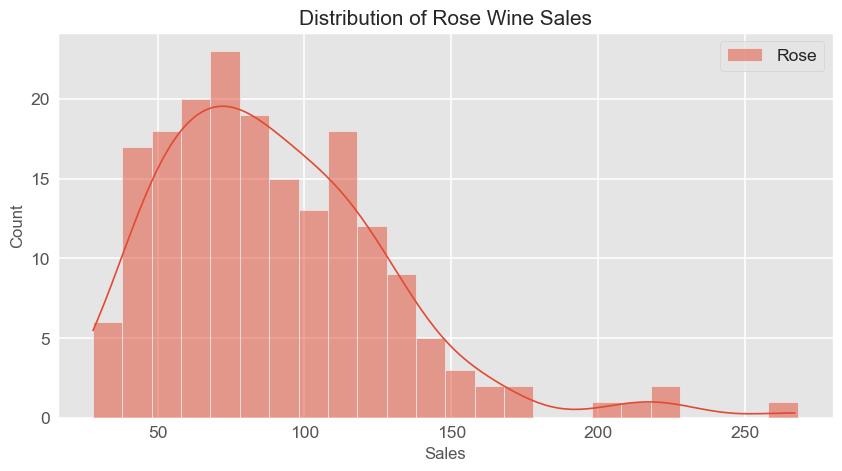

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=rose_df, binwidth=10, kde=True, ax=axs)
plt.xlabel("Sales")
plt.title("Distribution of Rose Wine Sales", size=15);
plt.savefig("images/Figure28.svg", bbox_inches="tight");

### Yearly Pointplot for Sales

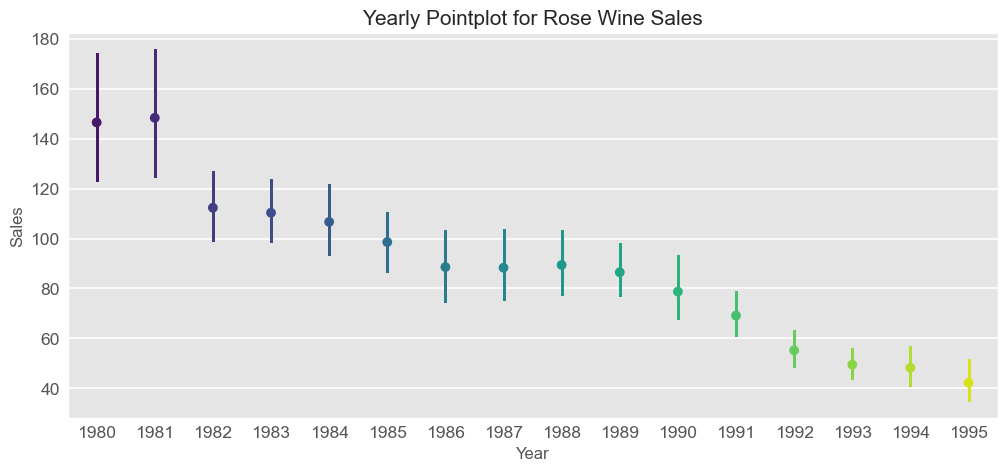

In [110]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
sns.pointplot(x=rose_df.index.year, y=rose_df.Rose, ax=axs, palette="viridis")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Yearly Pointplot for Rose Wine Sales", size=15);
plt.savefig("images/Figure29.svg", bbox_inches="tight");

### Monthly Sales Across Years

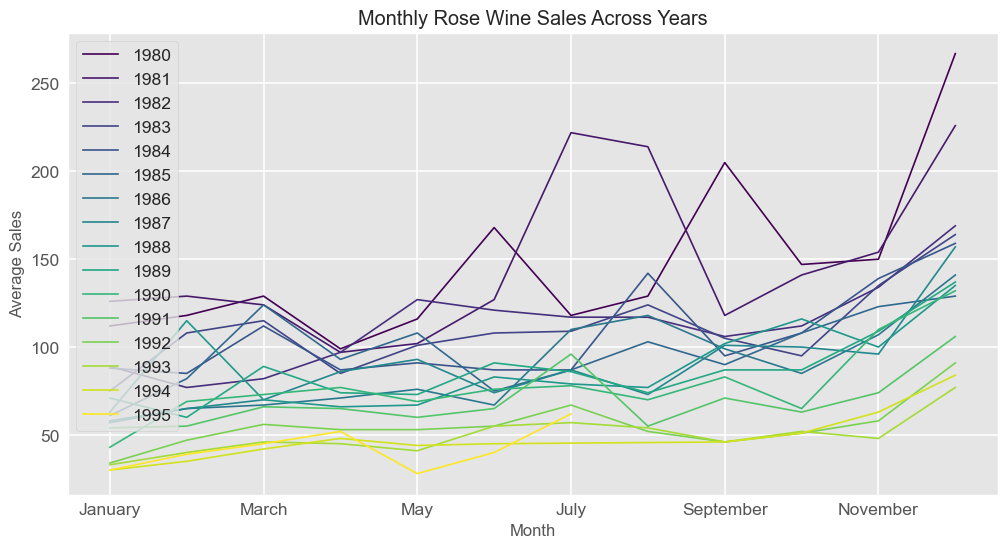

In [111]:
months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

monthly_sales_across_years = pd.pivot_table(
    rose_df,
    values='Rose',
    index=rose_df.index.year,
    columns=rose_df.index.month_name())

monthly_sales_across_years = monthly_sales_across_years.reindex(
    columns=months).T

monthly_sales_across_years.plot(
    ylabel="Average Sales",
    xlabel="Month",
    title="Monthly Rose Wine Sales Across Years",
    colormap='viridis',
    figsize=(12, 6))
plt.legend(loc='best');
plt.savefig("images/Figure30.svg", bbox_inches="tight");

### Decomposition

#### Additive Decomposition

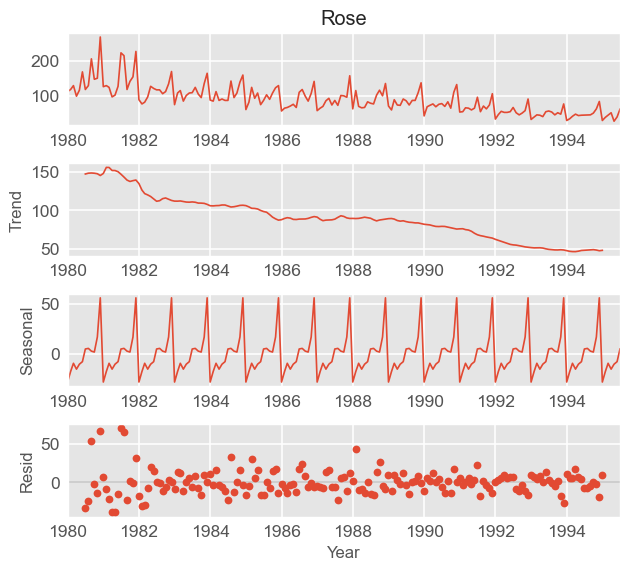

In [112]:
rose_decomposition = seasonal_decompose(rose_df["Rose"], model="add")
rose_decomposition.plot();
plt.xlabel("Year");
plt.savefig("images/Figure31_1.svg", bbox_inches="tight");

#### Multiplicative Decomposition

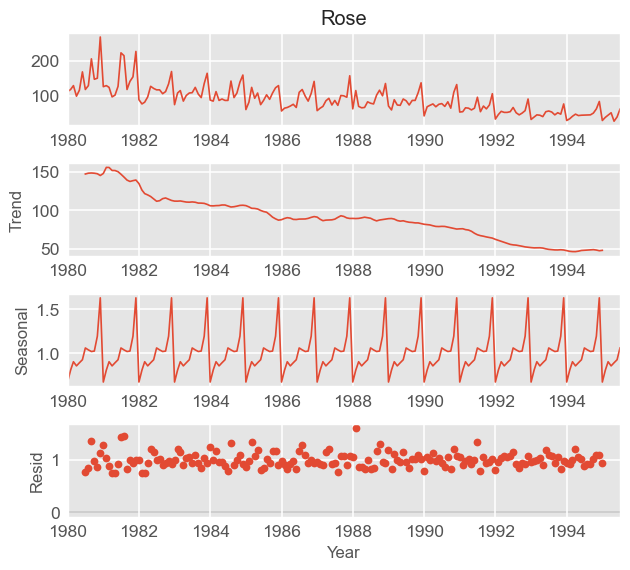

In [113]:
rose_decomposition = seasonal_decompose(rose_df["Rose"], model="multiplicative")
rose_decomposition.plot();
plt.xlabel("Year");
plt.savefig("images/Figure31_2.svg", bbox_inches="tight");

## 3. Split the data into training and test. The test data should start in 1991.

In [114]:
rose_train = rose_df.loc[rose_df.index.year < 1991]
rose_test = rose_df.loc[rose_df.index.year >= 1991]

In [115]:
print(f"Shape of the training data: {rose_train.shape}")
print(f"Shape of the testing data: {rose_test.shape}")

Shape of the training data: (132, 1)
Shape of the testing data: (55, 1)


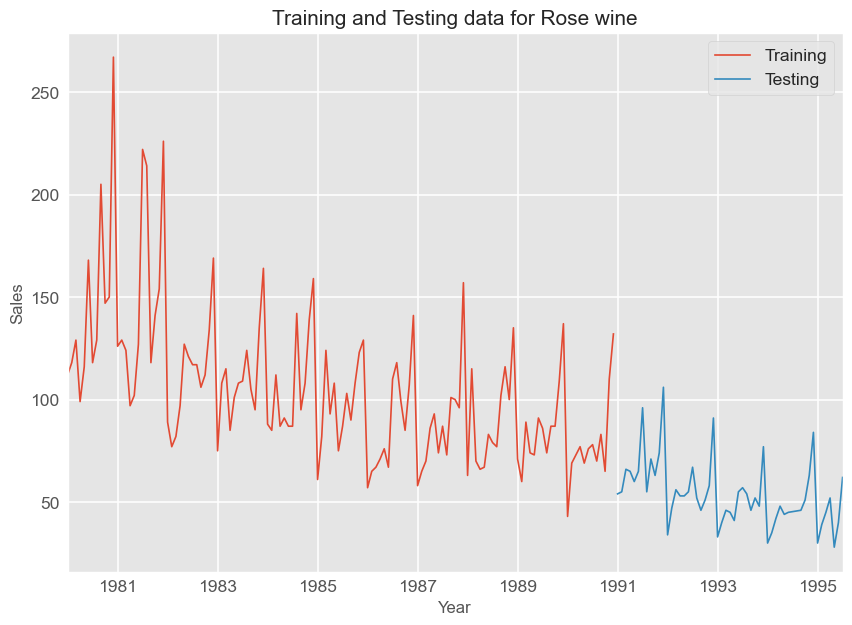

In [116]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_train.plot(ax=axs)
rose_test.plot(ax=axs)
axs.legend(["Training", "Testing"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Training and Testing data for Rose wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure32.svg", bbox_inches="tight");

## 4.  Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other additional models such as regression, naïve forecast models, simple average models, moving average models should also be built on the training data and check the performance on the test data using RMSE.

### Naive Forecast

In [117]:
rose_naive_train = rose_train.copy()
rose_naive_test = rose_test.copy()

In [118]:
rose_naive_test['Naive'] = np.asarray(rose_naive_train.iloc[len(rose_naive_train) - 1])[0]
rose_naive_test.head()

Rose  Naive
YearMonth              
1991-01-01  54.0  132.0
1991-02-01  55.0  132.0
1991-03-01  66.0  132.0
1991-04-01  65.0  132.0
1991-05-01  60.0  132.0

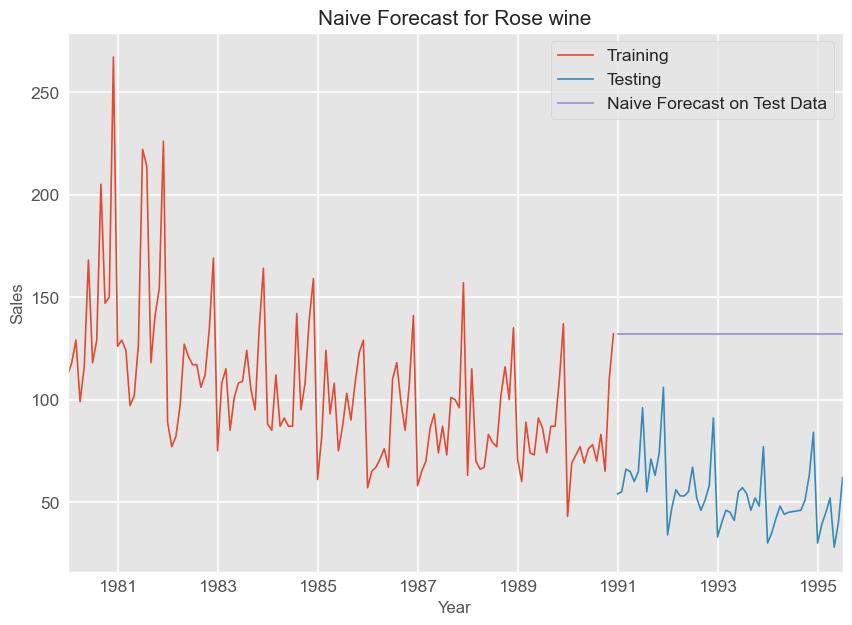

In [119]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_naive_train.plot(y="Rose", ax=axs)
rose_naive_test.plot(y="Rose", ax=axs)
rose_naive_test.plot(y="Naive", ax=axs)
axs.legend(["Training", "Testing", "Naive Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Naive Forecast for Rose wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure33.svg", bbox_inches="tight");

In [120]:
rose_naive_rmse = mean_squared_error(rose_naive_test["Rose"],
                                     rose_naive_test['Naive'],
                                     squared=False)
print(
    f"RMSE for Naive forecast model on Rose wine data: {rose_naive_rmse:.3f}")

RMSE for Naive forecast model on Rose wine data: 79.719


In [121]:
rose_results_df = pd.DataFrame({'Test RMSE': [rose_naive_rmse]},
                               index=['Naive Model'])

### Linear Regression

In [122]:
rose_linreg_train = rose_train.copy()
rose_linreg_test = rose_test.copy()

In [123]:
rose_linreg_train["Time"] = [i + 1 for i in range(len(rose_linreg_train))]
rose_linreg_test["Time"] = [i + 133 for i in range(len(rose_linreg_test))]

In [124]:
rose_linreg_train.head()

Rose  Time
YearMonth              
1980-01-01  112.0     1
1980-02-01  118.0     2
1980-03-01  129.0     3
1980-04-01   99.0     4
1980-05-01  116.0     5

In [125]:
rose_linreg_test.head()

Rose  Time
YearMonth             
1991-01-01  54.0   133
1991-02-01  55.0   134
1991-03-01  66.0   135
1991-04-01  65.0   136
1991-05-01  60.0   137

In [126]:
rose_lr = LinearRegression()
rose_lr.fit(rose_linreg_train[["Time"]], rose_linreg_train["Rose"])

LinearRegression()

In [127]:
rose_linreg_test["RegOnTime"] = rose_lr.predict(rose_linreg_test[["Time"]])

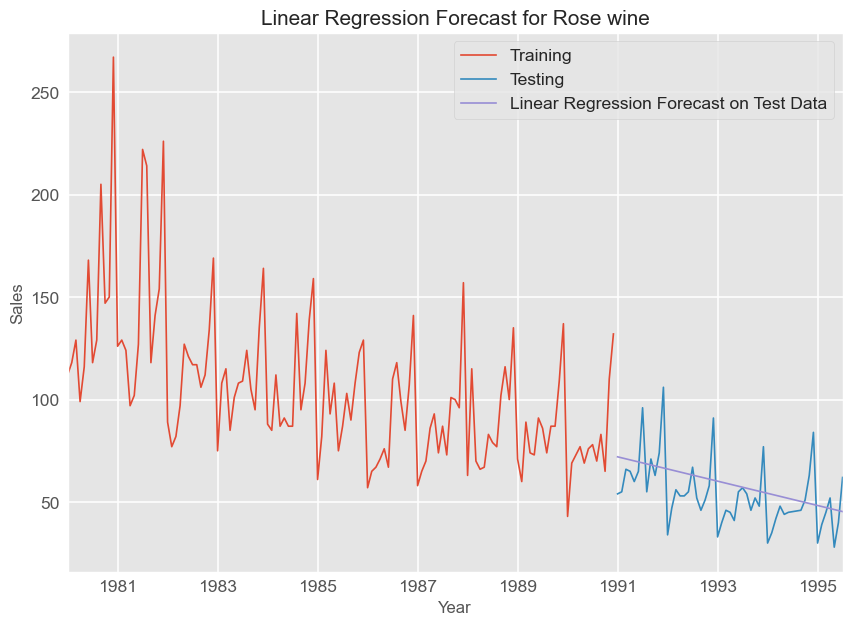

In [128]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_linreg_train.plot(y="Rose", ax=axs)
rose_linreg_test.plot(y="Rose", ax=axs)
rose_linreg_test.plot(y="RegOnTime", ax=axs)
axs.legend(["Training", "Testing", "Linear Regression Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Linear Regression Forecast for Rose wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure34.svg", bbox_inches="tight");

In [129]:
rose_linreg_rmse = mean_squared_error(rose_linreg_test["Rose"],
                                      rose_linreg_test['RegOnTime'],
                                      squared=False)
print(
    f"RMSE for Linear Regression forecast model on Rose wine data: {rose_linreg_rmse:.3f}"
)

RMSE for Linear Regression forecast model on Rose wine data: 15.269


In [130]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({'Test RMSE': [rose_linreg_rmse]},
                 index=['Linear Regression'])
])

### Simple Average Model

In [131]:
rose_sam_train = rose_train.copy()
rose_sam_test = rose_test.copy()

In [132]:
rose_sam_test["Average Forecast"] = rose_sam_train["Rose"].mean()
rose_sam_test.head()

Rose  Average Forecast
YearMonth                         
1991-01-01  54.0        104.939394
1991-02-01  55.0        104.939394
1991-03-01  66.0        104.939394
1991-04-01  65.0        104.939394
1991-05-01  60.0        104.939394

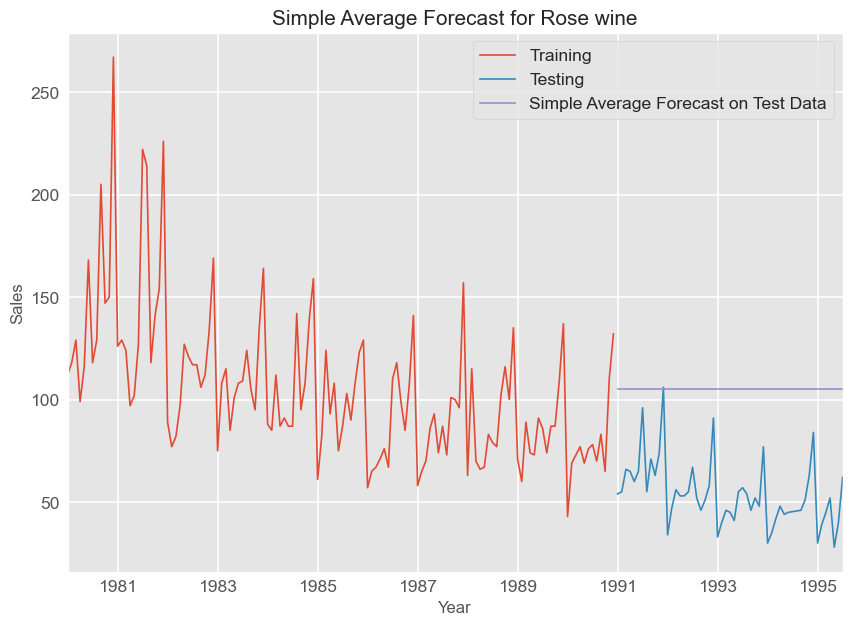

In [133]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_sam_train.plot(y="Rose", ax=axs)
rose_sam_test.plot(y="Rose", ax=axs)
rose_sam_test.plot(y="Average Forecast", ax=axs)
axs.legend(["Training", "Testing", "Simple Average Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Simple Average Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure35.svg", bbox_inches="tight");

In [134]:
rose_sam_rmse = mean_squared_error(
    rose_sam_test["Rose"], rose_sam_test["Average Forecast"], squared=False
)
print(
    f"RMSE for Simple Average forecast model on Rose wine data: {rose_sam_rmse:.3f}"
)

RMSE for Simple Average forecast model on Rose wine data: 53.461


In [135]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_sam_rmse]}, index=["Simple Average"]),
])

### Moving Average (MA) Model

In [136]:
rose_ma_df = rose_df.copy()

In [137]:
rose_ma_df["2-MA"] = rose_ma_df["Rose"].rolling(2).mean()
rose_ma_df["4-MA"] = rose_ma_df["Rose"].rolling(4).mean()
rose_ma_df["6-MA"] = rose_ma_df["Rose"].rolling(6).mean()
rose_ma_df["8-MA"] = rose_ma_df["Rose"].rolling(8).mean()

rose_ma_df.head()

Rose   2-MA   4-MA  6-MA  8-MA
YearMonth                                  
1980-01-01  112.0    NaN    NaN   NaN   NaN
1980-02-01  118.0  115.0    NaN   NaN   NaN
1980-03-01  129.0  123.5    NaN   NaN   NaN
1980-04-01   99.0  114.0  114.5   NaN   NaN
1980-05-01  116.0  107.5  115.5   NaN   NaN

In [138]:
rose_ma_train = rose_ma_df.loc[rose_ma_df.index.year < 1991]
rose_ma_test = rose_ma_df.loc[rose_ma_df.index.year >= 1991]

In [139]:
rose_ma_test.head()

Rose  2-MA   4-MA       6-MA    8-MA
YearMonth                                       
1991-01-01  54.0  93.0  90.25  85.666667  83.500
1991-02-01  55.0  54.5  87.75  83.166667  80.875
1991-03-01  66.0  60.5  76.75  80.333333  79.375
1991-04-01  65.0  65.5  60.00  80.333333  78.750
1991-05-01  60.0  62.5  61.50  72.000000  75.875

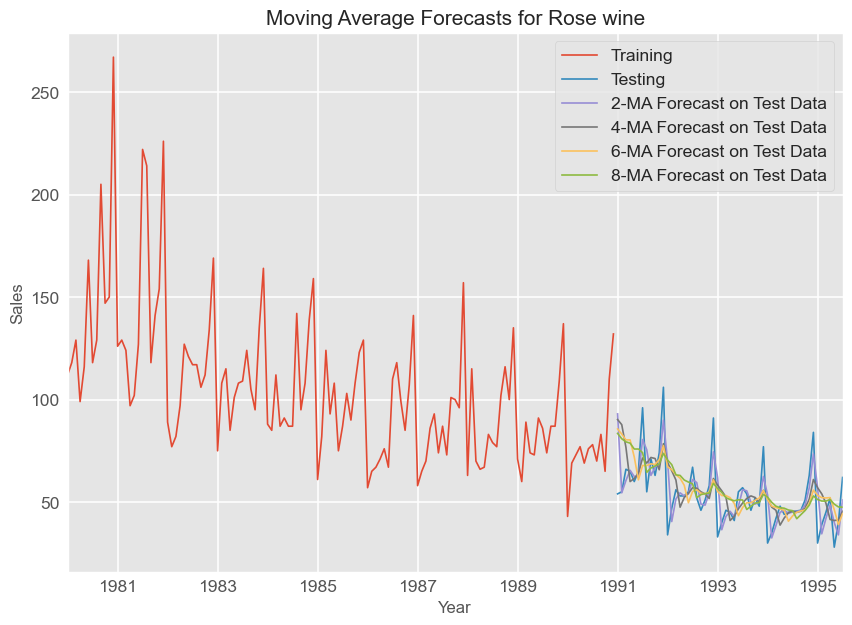

In [140]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_ma_train.plot(y="Rose", ax=axs)
rose_ma_test.plot(y="Rose", ax=axs)
rose_ma_test.plot(y="2-MA", ax=axs)
rose_ma_test.plot(y="4-MA", ax=axs)
rose_ma_test.plot(y="6-MA", ax=axs)
rose_ma_test.plot(y="8-MA", ax=axs)
axs.legend([
    "Training",
    "Testing",
    "2-MA Forecast on Test Data",
    "4-MA Forecast on Test Data",
    "6-MA Forecast on Test Data",
    "8-MA Forecast on Test Data",
])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Moving Average Forecasts for Rose wine",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure36.svg", bbox_inches="tight");

In [141]:
rose_2ma_rmse = mean_squared_error(rose_ma_test["Rose"], rose_ma_test["2-MA"], squared=False)
rose_4ma_rmse = mean_squared_error(rose_ma_test["Rose"], rose_ma_test["4-MA"], squared=False)
rose_6ma_rmse = mean_squared_error(rose_ma_test["Rose"], rose_ma_test["6-MA"], squared=False)
rose_8ma_rmse = mean_squared_error(rose_ma_test["Rose"], rose_ma_test["8-MA"], squared=False)

print(f"RMSE for 2-MA forecast model on Rose wine data: {rose_2ma_rmse:.3f}")
print(f"RMSE for 4-MA forecast model on Rose wine data: {rose_4ma_rmse:.3f}")
print(f"RMSE for 6-MA forecast model on Rose wine data: {rose_6ma_rmse:.3f}")
print(f"RMSE for 8-MA forecast model on Rose wine data: {rose_8ma_rmse:.3f}")

RMSE for 2-MA forecast model on Rose wine data: 11.529
RMSE for 4-MA forecast model on Rose wine data: 14.451
RMSE for 6-MA forecast model on Rose wine data: 14.566
RMSE for 8-MA forecast model on Rose wine data: 14.805


In [142]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_2ma_rmse]},
                 index=["2 Point Moving Average"])
])

### Simple Exponential Smoothing (SES) Model

In [143]:
rose_SES_train = rose_train.copy()
rose_SES_test = rose_test.copy()

In [144]:
rose_SES_model = SimpleExpSmoothing(rose_SES_train.Rose,
                                    initialization_method='estimated')
rose_SES_autofit = rose_SES_model.fit(optimized=True, method='ls')

In [145]:
rose_SES_autofit.params

{'smoothing_level': 0.099,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.387,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [146]:
rose_SES_test["Predictions"] = rose_SES_autofit.forecast(steps=len(rose_SES_test))
rose_SES_test.head()

Rose  Predictions
YearMonth                    
1991-01-01  54.0    87.104957
1991-02-01  55.0    87.104957
1991-03-01  66.0    87.104957
1991-04-01  65.0    87.104957
1991-05-01  60.0    87.104957

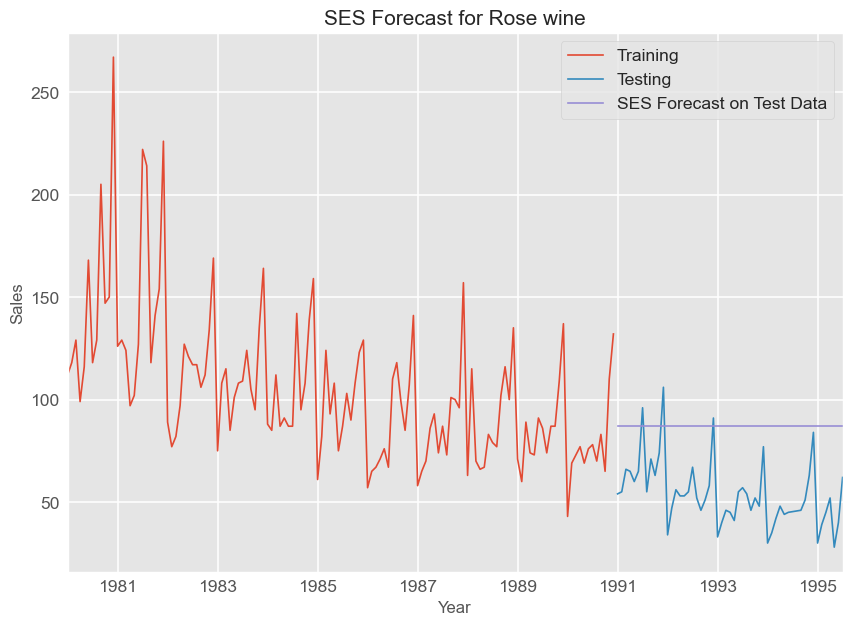

In [147]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_SES_train.plot(y="Rose", ax=axs)
rose_SES_test.plot(y="Rose", ax=axs)
rose_SES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "SES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("SES Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure37.svg", bbox_inches="tight");

In [148]:
rose_SES_rmse = mean_squared_error(rose_SES_test["Rose"],
                                   rose_SES_test["Predictions"],
                                   squared=False)
print(
    f"RMSE for SES forecast model on Rose wine data: {rose_SES_rmse:.3f}"
)

RMSE for SES forecast model on Rose wine data: 36.796


In [149]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_SES_rmse]},
                 index=["Alpha=0.09, SES"])
])

### Holt (Double Exponential Smoothing) Model

In [150]:
rose_DES_train = rose_train.copy()
rose_DES_test = rose_test.copy()

In [151]:
rose_DES_model = Holt(rose_DES_train.Rose, initialization_method='estimated')
rose_DES_autofit = rose_DES_model.fit(optimized=True, method='ls')

In [152]:
rose_DES_autofit.params

{'smoothing_level': 0.000,
 'smoothing_trend': 0.000,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 137.816,
 'initial_trend': -0.494,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [153]:
rose_DES_test["Predictions"] = rose_DES_autofit.forecast(steps=len(rose_DES_test))
rose_DES_test.head()

Rose  Predictions
YearMonth                    
1991-01-01  54.0    72.063488
1991-02-01  55.0    71.569112
1991-03-01  66.0    71.074735
1991-04-01  65.0    70.580359
1991-05-01  60.0    70.085982

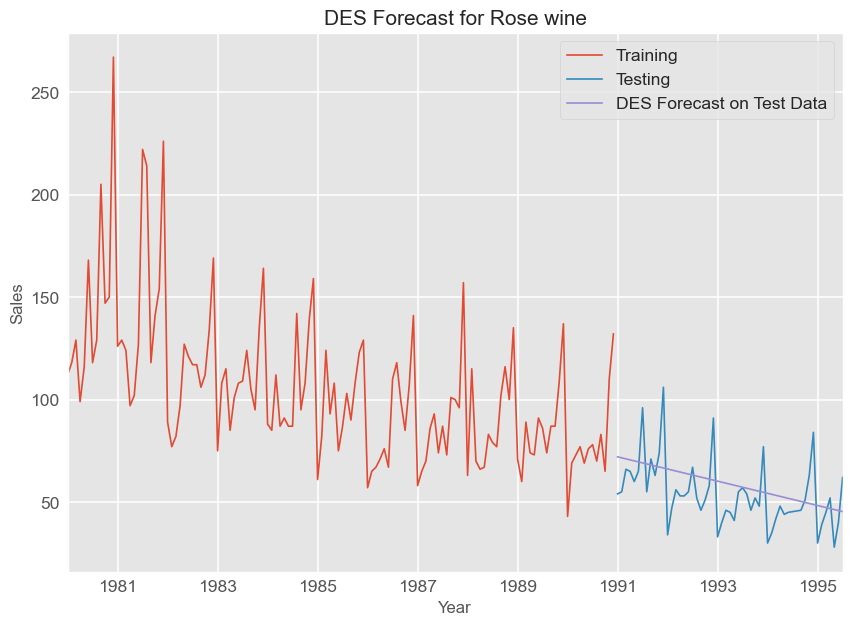

In [154]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_DES_train.plot(y="Rose", ax=axs)
rose_DES_test.plot(y="Rose", ax=axs)
rose_DES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "DES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("DES Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure38.svg", bbox_inches="tight");

In [155]:
rose_DES_rmse = mean_squared_error(rose_DES_test["Rose"],
                                   rose_DES_test["Predictions"],
                                   squared=False)
print(
    f"RMSE for DES forecast model on Rose wine data: {rose_DES_rmse:.3f}"
)

RMSE for DES forecast model on Rose wine data: 15.269


In [156]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_DES_rmse]},
                 index=["Alpha=0, Beta=0, DES"])
])

### Holt-Winters (Triple Exponential Smoothing) Model

In [157]:
rose_TES_train = rose_train.copy()
rose_TES_test = rose_test.copy()

In [158]:
rose_TES_model = ExponentialSmoothing(rose_TES_train.Rose,
                                      trend='additive',
                                      seasonal='additive',
                                      initialization_method='estimated')
rose_TES_autofit = rose_TES_model.fit(optimized=True, method='ls')

In [159]:
rose_TES_autofit.params

{'smoothing_level': 0.089,
 'smoothing_trend': 0.000,
 'smoothing_seasonal': 0.000,
 'damping_trend': nan,
 'initial_level': -4371.952,
 'initial_trend': -0.549,
 'initial_seasons': array([4487.565, 4499.933, 4507.936, 4497.303, 4506.125, 4511.583,
        4521.495, 4527.59 , 4523.593, 4521.687, 4539.782, 4582.058]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [160]:
rose_TES_test["Predictions"] = rose_TES_autofit.forecast(steps=len(rose_TES_test))
rose_TES_test.head()

Rose  Predictions
YearMonth                    
1991-01-01  54.0    42.607359
1991-02-01  55.0    54.425541
1991-03-01  66.0    61.880088
1991-04-01  65.0    50.698271
1991-05-01  60.0    58.970998

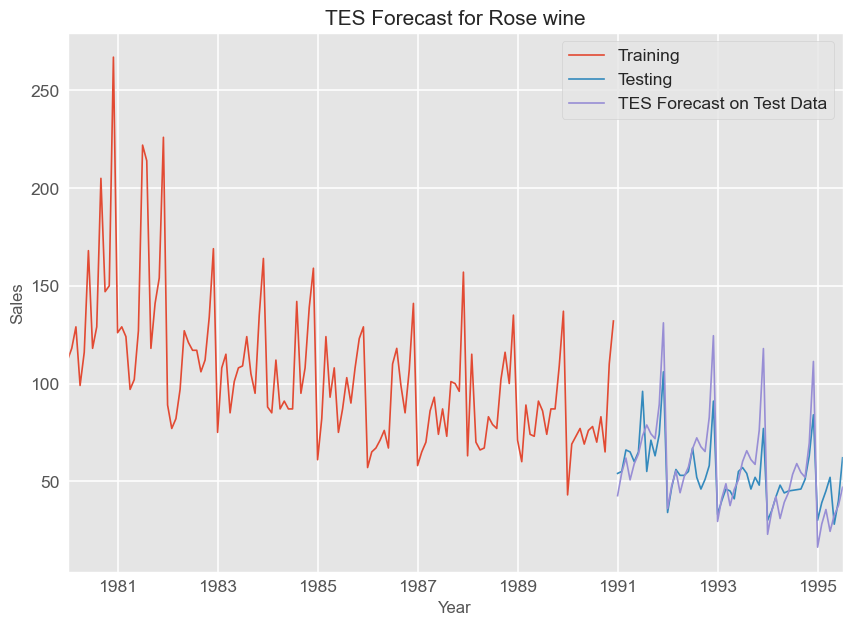

In [161]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_TES_train.plot(y="Rose", ax=axs)
rose_TES_test.plot(y="Rose", ax=axs)
rose_TES_test.plot(y="Predictions", ax=axs)
axs.legend(["Training", "Testing", "TES Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("TES Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure39.svg", bbox_inches="tight");

In [162]:
rose_TES_rmse = mean_squared_error(rose_TES_test["Rose"],
                                   rose_TES_test["Predictions"],
                                   squared=False)
print(f"RMSE for TES forecast model on Rose wine data: {rose_TES_rmse:.3f}")

RMSE for TES forecast model on Rose wine data: 14.257


In [163]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_TES_rmse]},
                 index=["Alpha=0.089, Beta=0, Gamma=0, TES"])
])

## 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.

### Checking for Stationarity on Whole data

In [164]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression='ct')
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    dfoutput["Critical Value (5%)"] = dftest[4]['5%']
    print(dfoutput)

In [165]:
adf_test(rose_df)

Results of Dickey-Fuller Test:
Test Statistic         -2.240431
p-value                 0.467137
#Lags Used             13.000000
Critical Value (5%)    -3.436179
dtype: float64


### Differencing and Checking for Stationarity of Whole data

In [166]:
adf_test(rose_df.diff(12).diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic         -4.550678
p-value                 0.001246
#Lags Used             11.000000
Critical Value (5%)    -3.437946
dtype: float64


### Checking for Stationarity on Training data

In [167]:
adf_test(rose_train)

Results of Dickey-Fuller Test:
Test Statistic         -1.686149
p-value                 0.756909
#Lags Used             13.000000
Critical Value (5%)    -3.448373
dtype: float64


### Differencing and Checking for Stationarity of Training data

In [168]:
rose_train_diff = rose_train.diff(12).diff().dropna()

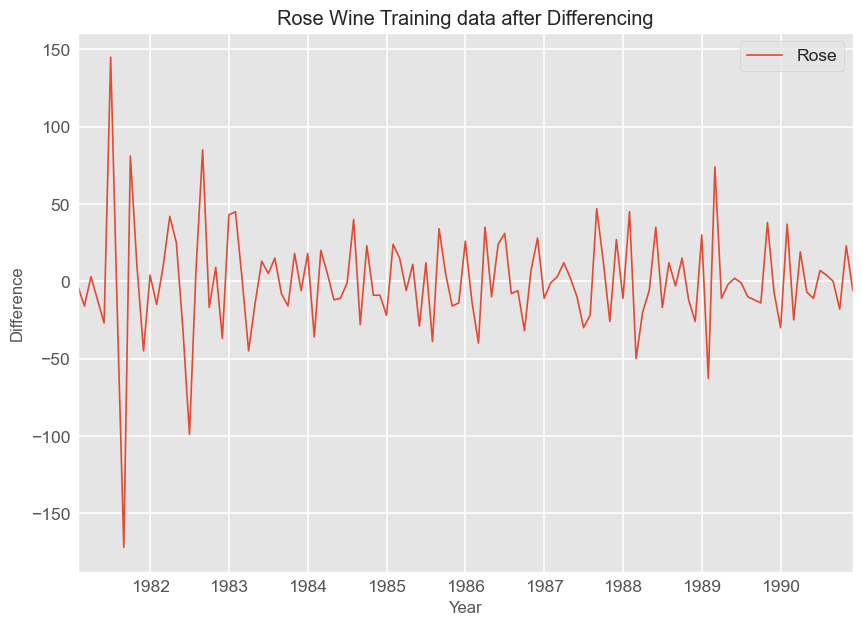

In [169]:
rose_train_diff.plot(title="Rose Wine Training data after Differencing",
                     xlabel="Year",
                     ylabel="Difference",
                     figsize=(10, 7));
plt.savefig("images/Figure40.svg", bbox_inches="tight");

In [170]:
adf_test(rose_train_diff)

Results of Dickey-Fuller Test:
Test Statistic         -3.631572
p-value                 0.027278
#Lags Used             11.000000
Critical Value (5%)    -3.452348
dtype: float64


## 6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

### Automated ARIMA(p, d, q) Model

In [171]:
import itertools

p = q = range(0, 4)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))
print('Some examples of the parameter combinations for the Model')
for i in range(0, 5):
    print(f'Model: {pdq[i]}')

Some examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)


In [172]:
rose_ARIMA_AIC = pd.DataFrame(columns=['parameters', 'AIC'])

for param in pdq:
    ARIMA_model = ARIMA(
        rose_train['Rose'].values,
        order=param,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(method='innovations_mle')

    print(f'ARIMA{param} - AIC:{ARIMA_model.aic}')

    rose_ARIMA_AIC = rose_ARIMA_AIC.append(
        {
            'parameters': param,
            'AIC': ARIMA_model.aic
        }, ignore_index=True)

ARIMA(0, 1, 0) - AIC:1323.9694343328088
ARIMA(0, 1, 1) - AIC:1263.5445256097369
ARIMA(0, 1, 2) - AIC:1251.6836347666435
ARIMA(0, 1, 3) - AIC:1244.0213114705596
ARIMA(1, 1, 0) - AIC:1308.1665634149206
ARIMA(1, 1, 1) - AIC:1262.2035774784822
ARIMA(1, 1, 2) - AIC:1251.9848433862658
ARIMA(1, 1, 3) - AIC:1245.6163402687928
ARIMA(2, 1, 0) - AIC:1280.2719510237027
ARIMA(2, 1, 1) - AIC:1263.2538103754596
ARIMA(2, 1, 2) - AIC:1253.9851932615763
ARIMA(2, 1, 3) - AIC:1243.8519455712587
ARIMA(3, 1, 0) - AIC:1269.8387266478858
ARIMA(3, 1, 1) - AIC:1255.360150219106
ARIMA(3, 1, 2) - AIC:1257.3845227063093
ARIMA(3, 1, 3) - AIC:1244.1647148133538


In [173]:
rose_ARIMA_AIC.sort_values(by='AIC', ascending=True).head()

parameters          AIC
11  (2, 1, 3)  1243.851946
3   (0, 1, 3)  1244.021311
15  (3, 1, 3)  1244.164715
7   (1, 1, 3)  1245.616340
2   (0, 1, 2)  1251.683635

In [174]:
rose_auto_ARIMA = ARIMA(
    rose_train['Rose'],
    order=(2, 1, 3),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

rose_results_auto_ARIMA = rose_auto_ARIMA.fit(method='innovations_mle')

print(rose_results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -615.926
Date:                Sun, 25 Sep 2022   AIC                           1243.852
Time:                        17:19:04   BIC                           1260.917
Sample:                    01-01-1980   HQIC                          1250.785
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7004      0.043    -39.121      0.000      -1.786      -1.615
ar.L2         -0.8639      0.048    -17.973      0.000      -0.958      -0.770
ma.L1          0.9718      0.116      8.402      0.0

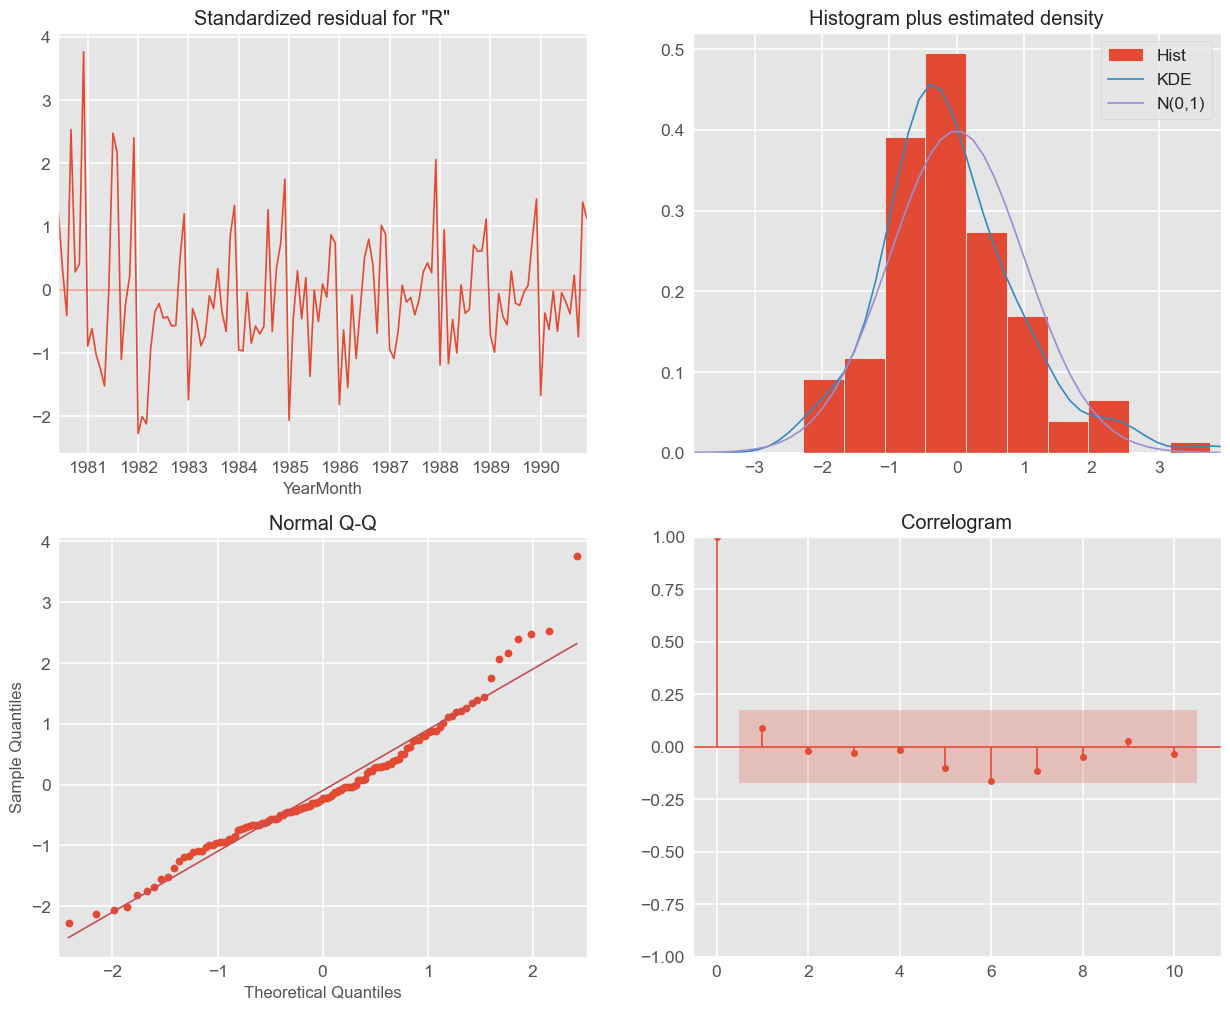

In [175]:
rose_results_auto_ARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure41.svg", bbox_inches="tight");

In [176]:
rose_predicted_auto_ARIMA = rose_results_auto_ARIMA.forecast(
    steps=len(rose_test))

In [177]:
rose_auto_ARIMA_rmse = mean_squared_error(rose_test["Rose"],
                                          rose_predicted_auto_ARIMA,
                                          squared=False)
print(
    f"RMSE for Auto ARIMA forecast model on Rose wine data: {rose_auto_ARIMA_rmse:.3f}"
)

RMSE for Auto ARIMA forecast model on Rose wine data: 36.239


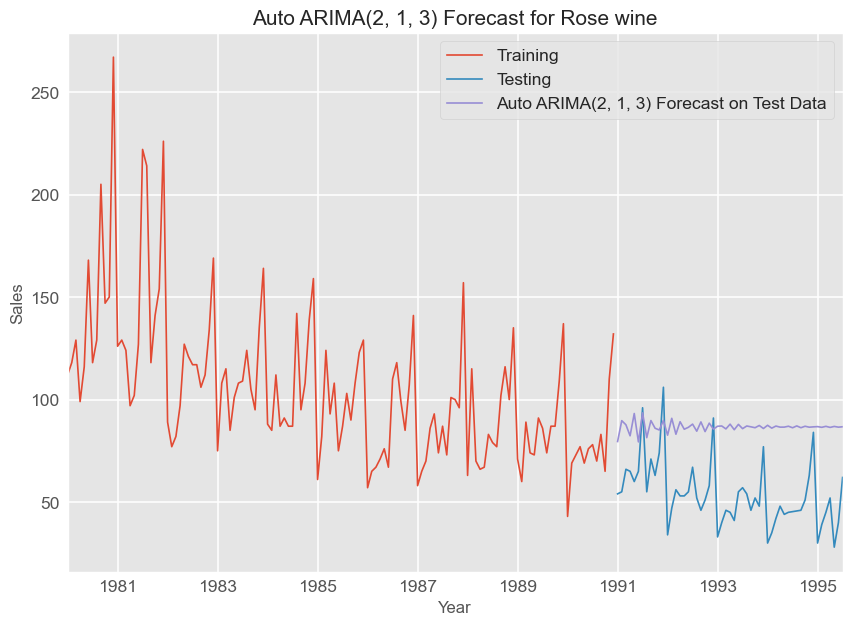

In [178]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_train.plot(y="Rose", ax=axs)
rose_test.plot(y="Rose", ax=axs)
rose_predicted_auto_ARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Auto ARIMA(2, 1, 3) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Auto ARIMA(2, 1, 3) Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure42.svg", bbox_inches="tight");

In [179]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_auto_ARIMA_rmse]},
                 index=["Auto ARIMA(2, 1, 3)"])
])

### Automated SARIMA(p, d, q)(P, D, Q, F) Model

In [180]:
p = q = range(0, 4)
d = D = range(1, 2)
pdq = list(itertools.product(p, d, q))
PDQF = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Some examples of the parameter combinations for the Model')
for i in range(0, 5):
    print('Model: {}{}'.format(pdq[i], PDQF[i]))

Some examples of the parameter combinations for the Model
Model: (0, 1, 0)(0, 1, 0, 12)
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 2)(0, 1, 2, 12)
Model: (0, 1, 3)(0, 1, 3, 12)
Model: (1, 1, 0)(1, 1, 0, 12)


In [220]:
rose_SARIMA_AIC = pd.DataFrame(columns=['parameters', 'seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in PDQF:
        SARIMA_model = sm.tsa.statespace.SARIMAX(
            rose_train['Rose'],
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=0, maxiter=100)

        print(f'SARIMA{param}{param_seasonal} - AIC:{SARIMA_model.aic}')

        rose_SARIMA_AIC = rose_SARIMA_AIC.append(
            {
                'parameters': param,
                'seasonal': param_seasonal,
                'AIC': SARIMA_model.aic
            },
            ignore_index=True)

SARIMA(0, 1, 0)(0, 1, 0, 12) - AIC:1171.2013438278946
SARIMA(0, 1, 0)(0, 1, 1, 12) - AIC:965.5057301627189
SARIMA(0, 1, 0)(0, 1, 2, 12) - AIC:845.8687014775944


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)(0, 1, 3, 12) - AIC:5708.413798591807
SARIMA(0, 1, 0)(1, 1, 0, 12) - AIC:982.3269589658804
SARIMA(0, 1, 0)(1, 1, 1, 12) - AIC:975.3375383601596
SARIMA(0, 1, 0)(1, 1, 2, 12) - AIC:847.7332182654623
SARIMA(0, 1, 0)(1, 1, 3, 12) - AIC:5740.257627046746
SARIMA(0, 1, 0)(2, 1, 0, 12) - AIC:858.5132698374409
SARIMA(0, 1, 0)(2, 1, 1, 12) - AIC:853.3390729143189
SARIMA(0, 1, 0)(2, 1, 2, 12) - AIC:842.6282244222587


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)(2, 1, 3, 12) - AIC:3278.4239677671735
SARIMA(0, 1, 0)(3, 1, 0, 12) - AIC:752.3958122739798
SARIMA(0, 1, 0)(3, 1, 1, 12) - AIC:748.316524649114
SARIMA(0, 1, 0)(3, 1, 2, 12) - AIC:748.9721713389762


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)(3, 1, 3, 12) - AIC:3706.033348749872
SARIMA(0, 1, 1)(0, 1, 0, 12) - AIC:1113.7663133562694
SARIMA(0, 1, 1)(0, 1, 1, 12) - AIC:915.0730606717805
SARIMA(0, 1, 1)(0, 1, 2, 12) - AIC:790.9032809266471


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)(0, 1, 3, 12) - AIC:5114.794136536269
SARIMA(0, 1, 1)(1, 1, 0, 12) - AIC:944.2456655530685
SARIMA(0, 1, 1)(1, 1, 1, 12) - AIC:929.3362488520054
SARIMA(0, 1, 1)(1, 1, 2, 12) - AIC:792.7161670277976


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)(1, 1, 3, 12) - AIC:331.5574050964083
SARIMA(0, 1, 1)(2, 1, 0, 12) - AIC:810.3194350158651
SARIMA(0, 1, 1)(2, 1, 1, 12) - AIC:804.1555753201801
SARIMA(0, 1, 1)(2, 1, 2, 12) - AIC:782.153871538608


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)(2, 1, 3, 12) - AIC:3233.5752614463813
SARIMA(0, 1, 1)(3, 1, 0, 12) - AIC:708.0834235666156
SARIMA(0, 1, 1)(3, 1, 1, 12) - AIC:699.7496884443732
SARIMA(0, 1, 1)(3, 1, 2, 12) - AIC:701.2071442263945
SARIMA(0, 1, 1)(3, 1, 3, 12) - AIC:3036.8921997218727
SARIMA(0, 1, 2)(0, 1, 0, 12) - AIC:1098.659802429173
SARIMA(0, 1, 2)(0, 1, 1, 12) - AIC:904.5003488471962
SARIMA(0, 1, 2)(0, 1, 2, 12) - AIC:784.0140955703747


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)(0, 1, 3, 12) - AIC:5001.848027024433
SARIMA(0, 1, 2)(1, 1, 0, 12) - AIC:941.5256923362796
SARIMA(0, 1, 2)(1, 1, 1, 12) - AIC:915.2731134090502
SARIMA(0, 1, 2)(1, 1, 2, 12) - AIC:785.8237144292738


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)(1, 1, 3, 12) - AIC:5752.9651503949
SARIMA(0, 1, 2)(2, 1, 0, 12) - AIC:811.5489438178329
SARIMA(0, 1, 2)(2, 1, 1, 12) - AIC:805.1158488730034
SARIMA(0, 1, 2)(2, 1, 2, 12) - AIC:774.9691206177656


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)(2, 1, 3, 12) - AIC:2100.741360776651
SARIMA(0, 1, 2)(3, 1, 0, 12) - AIC:709.6122118825612
SARIMA(0, 1, 2)(3, 1, 1, 12) - AIC:701.7010006134274
SARIMA(0, 1, 2)(3, 1, 2, 12) - AIC:703.3947030536465


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)(3, 1, 3, 12) - AIC:2744.004747785689
SARIMA(0, 1, 3)(0, 1, 0, 12) - AIC:1088.3764710136384
SARIMA(0, 1, 3)(0, 1, 1, 12) - AIC:897.1317873892924
SARIMA(0, 1, 3)(0, 1, 2, 12) - AIC:778.4427567850641


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)(0, 1, 3, 12) - AIC:4995.823546528912
SARIMA(0, 1, 3)(1, 1, 0, 12) - AIC:943.504308871434
SARIMA(0, 1, 3)(1, 1, 1, 12) - AIC:904.9319970114573
SARIMA(0, 1, 3)(1, 1, 2, 12) - AIC:780.2386079738859


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)(1, 1, 3, 12) - AIC:549.7837626695655
SARIMA(0, 1, 3)(2, 1, 0, 12) - AIC:813.4051893208915
SARIMA(0, 1, 3)(2, 1, 1, 12) - AIC:806.4667725196724
SARIMA(0, 1, 3)(2, 1, 2, 12) - AIC:767.2243745893053
SARIMA(0, 1, 3)(2, 1, 3, 12) - AIC:3286.772907573619
SARIMA(0, 1, 3)(3, 1, 0, 12) - AIC:711.7218300858334
SARIMA(0, 1, 3)(3, 1, 1, 12) - AIC:703.8986523700366
SARIMA(0, 1, 3)(3, 1, 2, 12) - AIC:705.3781294773861
SARIMA(0, 1, 3)(3, 1, 3, 12) - AIC:3102.6764500152817
SARIMA(1, 1, 0)(0, 1, 0, 12) - AIC:1164.5103013842013
SARIMA(1, 1, 0)(0, 1, 1, 12) - AIC:953.8813887546747
SARIMA(1, 1, 0)(0, 1, 2, 12) - AIC:828.8398832821197


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)(0, 1, 3, 12) - AIC:5907.263304442144
SARIMA(1, 1, 0)(1, 1, 0, 12) - AIC:962.9698535736214
SARIMA(1, 1, 0)(1, 1, 1, 12) - AIC:964.8516934823685
SARIMA(1, 1, 0)(1, 1, 2, 12) - AIC:830.3075804966968


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)(1, 1, 3, 12) - AIC:3730.504043413611
SARIMA(1, 1, 0)(2, 1, 0, 12) - AIC:826.9995808091105
SARIMA(1, 1, 0)(2, 1, 1, 12) - AIC:823.8261102788138
SARIMA(1, 1, 0)(2, 1, 2, 12) - AIC:825.0437253059806


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)(2, 1, 3, 12) - AIC:3506.125522665683
SARIMA(1, 1, 0)(3, 1, 0, 12) - AIC:727.366908412656
SARIMA(1, 1, 0)(3, 1, 1, 12) - AIC:728.9034690439208
SARIMA(1, 1, 0)(3, 1, 2, 12) - AIC:721.9926145268884


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)(3, 1, 3, 12) - AIC:3314.8327118204884
SARIMA(1, 1, 1)(0, 1, 0, 12) - AIC:1110.6209464400824
SARIMA(1, 1, 1)(0, 1, 1, 12) - AIC:914.045384498812
SARIMA(1, 1, 1)(0, 1, 2, 12) - AIC:792.3411370856574


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)(0, 1, 3, 12) - AIC:5179.766076483138
SARIMA(1, 1, 1)(1, 1, 0, 12) - AIC:933.2974216823706
SARIMA(1, 1, 1)(1, 1, 1, 12) - AIC:927.2920638200442
SARIMA(1, 1, 1)(1, 1, 2, 12) - AIC:794.1929706683601


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)(1, 1, 3, 12) - AIC:nan
SARIMA(1, 1, 1)(2, 1, 0, 12) - AIC:799.9474258321458
SARIMA(1, 1, 1)(2, 1, 1, 12) - AIC:791.9065436343756
SARIMA(1, 1, 1)(2, 1, 2, 12) - AIC:783.8990945072771


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)(2, 1, 3, 12) - AIC:3276.979229683112
SARIMA(1, 1, 1)(3, 1, 0, 12) - AIC:702.1669809758819
SARIMA(1, 1, 1)(3, 1, 1, 12) - AIC:693.9370826994166
SARIMA(1, 1, 1)(3, 1, 2, 12) - AIC:695.0475363727365
SARIMA(1, 1, 1)(3, 1, 3, 12) - AIC:3088.006119228211
SARIMA(1, 1, 2)(0, 1, 0, 12) - AIC:1096.3571024945584
SARIMA(1, 1, 2)(0, 1, 1, 12) - AIC:906.4966907624955
SARIMA(1, 1, 2)(0, 1, 2, 12) - AIC:785.9832738920124


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)(0, 1, 3, 12) - AIC:5288.168961295589
SARIMA(1, 1, 2)(1, 1, 0, 12) - AIC:934.887039243841
SARIMA(1, 1, 2)(1, 1, 1, 12) - AIC:917.2527818410052
SARIMA(1, 1, 2)(1, 1, 2, 12) - AIC:787.7843970224072
SARIMA(1, 1, 2)(1, 1, 3, 12) - AIC:5754.1202500938125
SARIMA(1, 1, 2)(2, 1, 0, 12) - AIC:801.9382052144886
SARIMA(1, 1, 2)(2, 1, 1, 12) - AIC:791.9171141517513
SARIMA(1, 1, 2)(2, 1, 2, 12) - AIC:776.9401072614643


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)(2, 1, 3, 12) - AIC:3278.1655706256406
SARIMA(1, 1, 2)(3, 1, 0, 12) - AIC:703.80755225749
SARIMA(1, 1, 2)(3, 1, 1, 12) - AIC:696.108584607442
SARIMA(1, 1, 2)(3, 1, 2, 12) - AIC:697.0470528368188


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)(3, 1, 3, 12) - AIC:3091.5991398672877
SARIMA(1, 1, 3)(0, 1, 0, 12) - AIC:1088.0914860027358
SARIMA(1, 1, 3)(0, 1, 1, 12) - AIC:895.9867971325275
SARIMA(1, 1, 3)(0, 1, 2, 12) - AIC:780.3059561915769


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(0, 1, 3, 12) - AIC:5138.4091202765485
SARIMA(1, 1, 3)(1, 1, 0, 12) - AIC:936.6664092075694
SARIMA(1, 1, 3)(1, 1, 1, 12) - AIC:906.7653660392867
SARIMA(1, 1, 3)(1, 1, 2, 12) - AIC:782.1027704584831


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(1, 1, 3, 12) - AIC:18.0
SARIMA(1, 1, 3)(2, 1, 0, 12) - AIC:803.6616207206966
SARIMA(1, 1, 3)(2, 1, 1, 12) - AIC:793.9162134687119
SARIMA(1, 1, 3)(2, 1, 2, 12) - AIC:767.4754244092101


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(2, 1, 3, 12) - AIC:3154.2152082844927
SARIMA(1, 1, 3)(3, 1, 0, 12) - AIC:702.9343087361428


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(3, 1, 1, 12) - AIC:696.5863928360906


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(3, 1, 2, 12) - AIC:698.0881259053533


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)(3, 1, 3, 12) - AIC:2970.0630581309333
SARIMA(2, 1, 0)(0, 1, 0, 12) - AIC:1133.2467704396647
SARIMA(2, 1, 0)(0, 1, 1, 12) - AIC:949.5332566879526
SARIMA(2, 1, 0)(0, 1, 2, 12) - AIC:827.1933387102592


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)(0, 1, 3, 12) - AIC:5892.614829912034
SARIMA(2, 1, 0)(1, 1, 0, 12) - AIC:950.2637728229417
SARIMA(2, 1, 0)(1, 1, 1, 12) - AIC:952.2623518887174
SARIMA(2, 1, 0)(1, 1, 2, 12) - AIC:828.7198703673249


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)(1, 1, 3, 12) - AIC:4234.555218366322
SARIMA(2, 1, 0)(2, 1, 0, 12) - AIC:814.2969261795408
SARIMA(2, 1, 0)(2, 1, 1, 12) - AIC:808.5100914938972
SARIMA(2, 1, 0)(2, 1, 2, 12) - AIC:810.0074804178173


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)(2, 1, 3, 12) - AIC:3448.0319657609552
SARIMA(2, 1, 0)(3, 1, 0, 12) - AIC:714.7788976436868
SARIMA(2, 1, 0)(3, 1, 1, 12) - AIC:705.0868021018
SARIMA(2, 1, 0)(3, 1, 2, 12) - AIC:707.1846925549611


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)(3, 1, 3, 12) - AIC:3022.900570798114
SARIMA(2, 1, 1)(0, 1, 0, 12) - AIC:1107.1166362359797
SARIMA(2, 1, 1)(0, 1, 1, 12) - AIC:915.1236479112556
SARIMA(2, 1, 1)(0, 1, 2, 12) - AIC:794.2799626277586


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)(0, 1, 3, 12) - AIC:5242.032308768791
SARIMA(2, 1, 1)(1, 1, 0, 12) - AIC:926.3197036268087
SARIMA(2, 1, 1)(1, 1, 1, 12) - AIC:928.3197020908607
SARIMA(2, 1, 1)(1, 1, 2, 12) - AIC:796.1300001391561


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)(1, 1, 3, 12) - AIC:5855.12428359022
SARIMA(2, 1, 1)(2, 1, 0, 12) - AIC:792.8940753933872
SARIMA(2, 1, 1)(2, 1, 1, 12) - AIC:784.8928050997196
SARIMA(2, 1, 1)(2, 1, 2, 12) - AIC:785.8335672738051


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)(2, 1, 3, 12) - AIC:3650.059525404634
SARIMA(2, 1, 1)(3, 1, 0, 12) - AIC:694.938677289548
SARIMA(2, 1, 1)(3, 1, 1, 12) - AIC:687.9965370074257
SARIMA(2, 1, 1)(3, 1, 2, 12) - AIC:688.909863700839


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)(3, 1, 3, 12) - AIC:3460.243377083913
SARIMA(2, 1, 2)(0, 1, 0, 12) - AIC:1099.4823964820919
SARIMA(2, 1, 2)(0, 1, 1, 12) - AIC:904.7004130509902
SARIMA(2, 1, 2)(0, 1, 2, 12) - AIC:784.1409509063358


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(0, 1, 3, 12) - AIC:5076.535642289981
SARIMA(2, 1, 2)(1, 1, 0, 12) - AIC:925.3705668173565
SARIMA(2, 1, 2)(1, 1, 1, 12) - AIC:915.6932508749387
SARIMA(2, 1, 2)(1, 1, 2, 12) - AIC:785.8335737082895


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(1, 1, 3, 12) - AIC:2092.704022138105
SARIMA(2, 1, 2)(2, 1, 0, 12) - AIC:794.7799442943597
SARIMA(2, 1, 2)(2, 1, 1, 12) - AIC:783.7036522679398
SARIMA(2, 1, 2)(2, 1, 2, 12) - AIC:776.9961006251345


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(2, 1, 3, 12) - AIC:3330.008091871305
SARIMA(2, 1, 2)(3, 1, 0, 12) - AIC:696.8666403413824
SARIMA(2, 1, 2)(3, 1, 1, 12) - AIC:688.2483954034832


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(3, 1, 2, 12) - AIC:689.7859643724


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(3, 1, 3, 12) - AIC:3143.428134352499
SARIMA(2, 1, 3)(0, 1, 0, 12) - AIC:1089.5368830867726
SARIMA(2, 1, 3)(0, 1, 1, 12) - AIC:897.1805344662926
SARIMA(2, 1, 3)(0, 1, 2, 12) - AIC:779.1301959276326


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)(0, 1, 3, 12) - AIC:5210.760070471806
SARIMA(2, 1, 3)(1, 1, 0, 12) - AIC:919.0020069076352
SARIMA(2, 1, 3)(1, 1, 1, 12) - AIC:902.2459019493702
SARIMA(2, 1, 3)(1, 1, 2, 12) - AIC:780.6508317409367
SARIMA(2, 1, 3)(1, 1, 3, 12) - AIC:5675.00418539952
SARIMA(2, 1, 3)(2, 1, 0, 12) - AIC:792.233922140857
SARIMA(2, 1, 3)(2, 1, 1, 12) - AIC:787.7533231671572
SARIMA(2, 1, 3)(2, 1, 2, 12) - AIC:769.4962114400913


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)(2, 1, 3, 12) - AIC:3232.409205552757
SARIMA(2, 1, 3)(3, 1, 0, 12) - AIC:694.5858505702996
SARIMA(2, 1, 3)(3, 1, 1, 12) - AIC:691.0770815263669


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)(3, 1, 2, 12) - AIC:692.3315508130164


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)(3, 1, 3, 12) - AIC:3048.1862247893782
SARIMA(3, 1, 0)(0, 1, 0, 12) - AIC:1119.1809056019017
SARIMA(3, 1, 0)(0, 1, 1, 12) - AIC:943.5417009330384
SARIMA(3, 1, 0)(0, 1, 2, 12) - AIC:822.446931112061


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)(0, 1, 3, 12) - AIC:5890.208360064214
SARIMA(3, 1, 0)(1, 1, 0, 12) - AIC:930.6943146016702
SARIMA(3, 1, 0)(1, 1, 1, 12) - AIC:932.4901496959385
SARIMA(3, 1, 0)(1, 1, 2, 12) - AIC:824.1779575724433


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)(1, 1, 3, 12) - AIC:5929.744968430702
SARIMA(3, 1, 0)(2, 1, 0, 12) - AIC:803.7674514642858
SARIMA(3, 1, 0)(2, 1, 1, 12) - AIC:794.863403530278
SARIMA(3, 1, 0)(2, 1, 2, 12) - AIC:796.6369790758058


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)(2, 1, 3, 12) - AIC:3546.546597762622
SARIMA(3, 1, 0)(3, 1, 0, 12) - AIC:704.8546570596666
SARIMA(3, 1, 0)(3, 1, 1, 12) - AIC:696.8642292312016
SARIMA(3, 1, 0)(3, 1, 2, 12) - AIC:699.0912731178802


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)(3, 1, 3, 12) - AIC:3272.94988879891
SARIMA(3, 1, 1)(0, 1, 0, 12) - AIC:1099.63308654422
SARIMA(3, 1, 1)(0, 1, 1, 12) - AIC:915.5227261302427
SARIMA(3, 1, 1)(0, 1, 2, 12) - AIC:795.1857811464505


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)(0, 1, 3, 12) - AIC:5819.858127404824
SARIMA(3, 1, 1)(1, 1, 0, 12) - AIC:914.558066931492
SARIMA(3, 1, 1)(1, 1, 1, 12) - AIC:916.4809813444101
SARIMA(3, 1, 1)(1, 1, 2, 12) - AIC:796.8065566403659
SARIMA(3, 1, 1)(1, 1, 3, 12) - AIC:5858.871977099864
SARIMA(3, 1, 1)(2, 1, 0, 12) - AIC:785.3678771580436
SARIMA(3, 1, 1)(2, 1, 1, 12) - AIC:777.360396484983
SARIMA(3, 1, 1)(2, 1, 2, 12) - AIC:777.5853448597468


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)(2, 1, 3, 12) - AIC:3652.3707188209864
SARIMA(3, 1, 1)(3, 1, 0, 12) - AIC:688.5642274584225
SARIMA(3, 1, 1)(3, 1, 1, 12) - AIC:681.3628071966639
SARIMA(3, 1, 1)(3, 1, 2, 12) - AIC:682.3207007812762


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)(3, 1, 3, 12) - AIC:3418.9715742634753
SARIMA(3, 1, 2)(0, 1, 0, 12) - AIC:1097.5317771848747
SARIMA(3, 1, 2)(0, 1, 1, 12) - AIC:906.5708111893749
SARIMA(3, 1, 2)(0, 1, 2, 12) - AIC:787.9521881774689


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)(0, 1, 3, 12) - AIC:5289.530042372091
SARIMA(3, 1, 2)(1, 1, 0, 12) - AIC:915.6058897262405
SARIMA(3, 1, 2)(1, 1, 1, 12) - AIC:917.4091482083111
SARIMA(3, 1, 2)(1, 1, 2, 12) - AIC:789.5119881081403


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)(1, 1, 3, 12) - AIC:5681.4077071547645
SARIMA(3, 1, 2)(2, 1, 0, 12) - AIC:786.7471041580011
SARIMA(3, 1, 2)(2, 1, 1, 12) - AIC:777.2616168689063
SARIMA(3, 1, 2)(2, 1, 2, 12) - AIC:778.7252773069138
SARIMA(3, 1, 2)(2, 1, 3, 12) - AIC:3225.156515820486
SARIMA(3, 1, 2)(3, 1, 0, 12) - AIC:687.938484142383
SARIMA(3, 1, 2)(3, 1, 1, 12) - AIC:683.211700004688
SARIMA(3, 1, 2)(3, 1, 2, 12) - AIC:684.0142387807185


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)(3, 1, 3, 12) - AIC:3039.725006198956
SARIMA(3, 1, 3)(0, 1, 0, 12) - AIC:1090.4366088406848
SARIMA(3, 1, 3)(0, 1, 1, 12) - AIC:899.8002914536669
SARIMA(3, 1, 3)(0, 1, 2, 12) - AIC:780.7435169368036
SARIMA(3, 1, 3)(0, 1, 3, 12) - AIC:587.3673091854328
SARIMA(3, 1, 3)(1, 1, 0, 12) - AIC:919.3449764026059
SARIMA(3, 1, 3)(1, 1, 1, 12) - AIC:907.6982326687954
SARIMA(3, 1, 3)(1, 1, 2, 12) - AIC:782.5614968060596
SARIMA(3, 1, 3)(1, 1, 3, 12) - AIC:521.9969380715695
SARIMA(3, 1, 3)(2, 1, 0, 12) - AIC:785.2892994206638
SARIMA(3, 1, 3)(2, 1, 1, 12) - AIC:777.7748456464639
SARIMA(3, 1, 3)(2, 1, 2, 12) - AIC:770.2518565554271


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)(2, 1, 3, 12) - AIC:597.5408614207022
SARIMA(3, 1, 3)(3, 1, 0, 12) - AIC:689.5019222039136
SARIMA(3, 1, 3)(3, 1, 1, 12) - AIC:681.6084845463242


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)(3, 1, 2, 12) - AIC:681.9852001253456


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)(3, 1, 3, 12) - AIC:650.9359906028549


In [268]:
rose_SARIMA_AIC.sort_values(by='AIC', ascending=True).iloc[7:12]

parameters       seasonal         AIC
221  (3, 1, 1)  (3, 1, 1, 12)  681.362807
253  (3, 1, 3)  (3, 1, 1, 12)  681.608485
254  (3, 1, 3)  (3, 1, 2, 12)  681.985200
222  (3, 1, 1)  (3, 1, 2, 12)  682.320701
237  (3, 1, 2)  (3, 1, 1, 12)  683.211700

In [181]:
rose_auto_SARIMA = sm.tsa.statespace.SARIMAX(
    rose_train['Rose'],
    order=(3, 1, 1),
    seasonal_order=(3, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

rose_results_auto_SARIMA = rose_auto_SARIMA.fit(disp=False, maxiter=10000)

print(rose_results_auto_SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -331.681
Date:                            Sun, 25 Sep 2022   AIC                            681.363
Time:                                    17:19:36   BIC                            702.801
Sample:                                01-01-1980   HQIC                           689.958
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0173      0.151      0.114      0.909      -0.279       0.314
ar.L2         -0.0426      0.141   

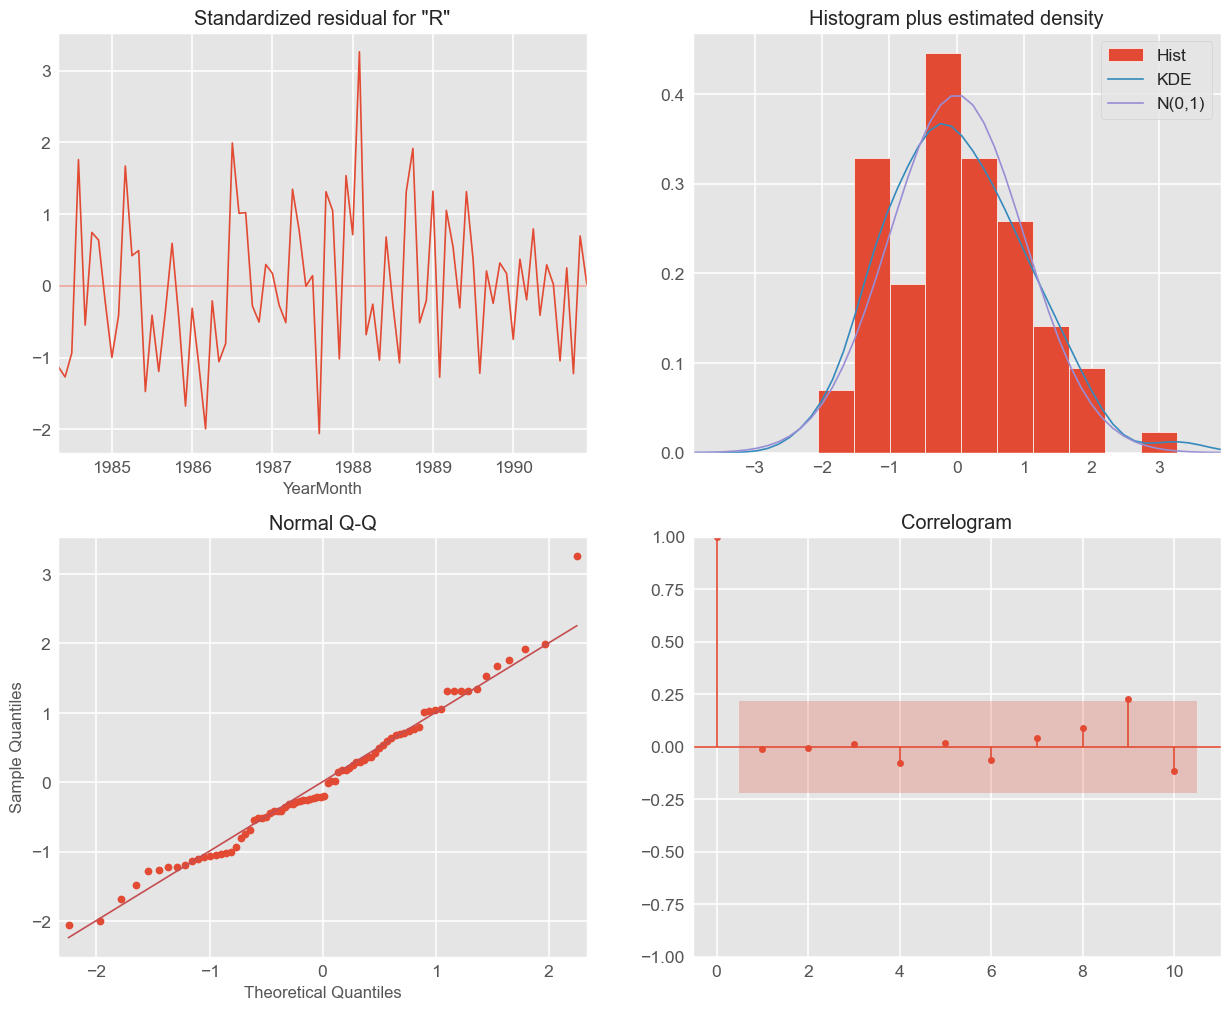

In [182]:
rose_results_auto_SARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure43.svg", bbox_inches="tight");

In [183]:
rose_predicted_auto_SARIMA = rose_results_auto_SARIMA.forecast(
    steps=len(rose_test))

In [184]:
rose_auto_SARIMA_rmse = mean_squared_error(rose_test.Rose,
                                           rose_predicted_auto_SARIMA,
                                           squared=False)
print(
    f"RMSE for Auto SARIMA forecast model on Rose wine data: {rose_auto_SARIMA_rmse:.3f}"
)

RMSE for Auto SARIMA forecast model on Rose wine data: 16.824


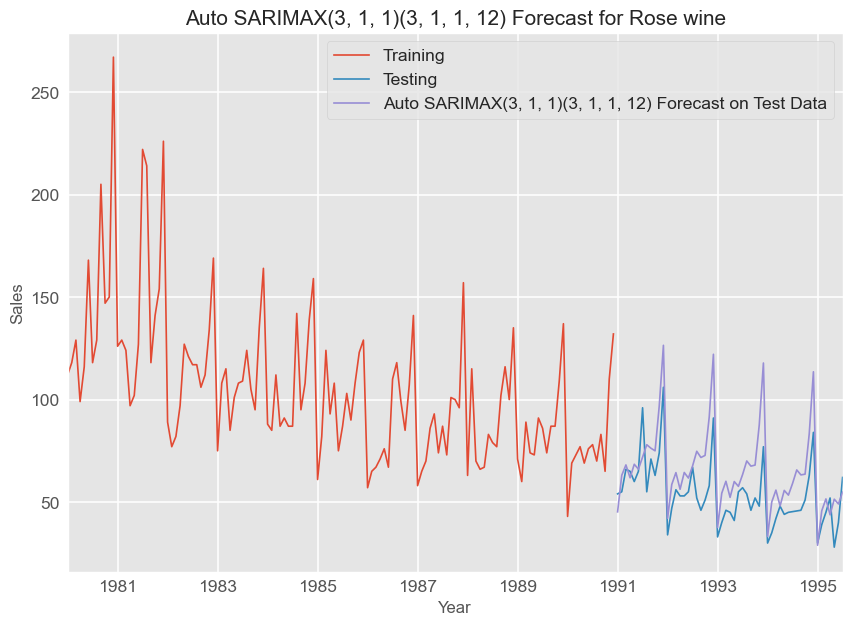

In [185]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_train.plot(y="Rose", ax=axs)
rose_test.plot(y="Rose", ax=axs)
rose_predicted_auto_SARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Auto SARIMAX(3, 1, 1)(3, 1, 1, 12) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Auto SARIMAX(3, 1, 1)(3, 1, 1, 12) Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure44.svg", bbox_inches="tight");

In [186]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_auto_SARIMA_rmse]},
                 index=["Auto SARIMAX(3, 1, 1)(3, 1, 1, 12)"])
])

## 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

### PACF Plot

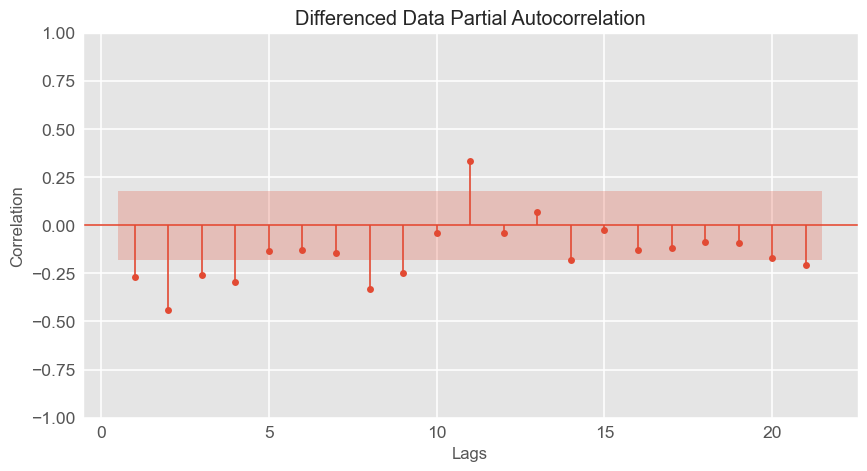

In [187]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_pacf(rose_train_diff,
          zero=False,
          title='Differenced Data Partial Autocorrelation',
          ax=axs)
axs.set_xlabel("Lags")
axs.set_ylabel("Correlation");
plt.savefig("images/Figure45.svg", bbox_inches="tight");

### ACF Plot

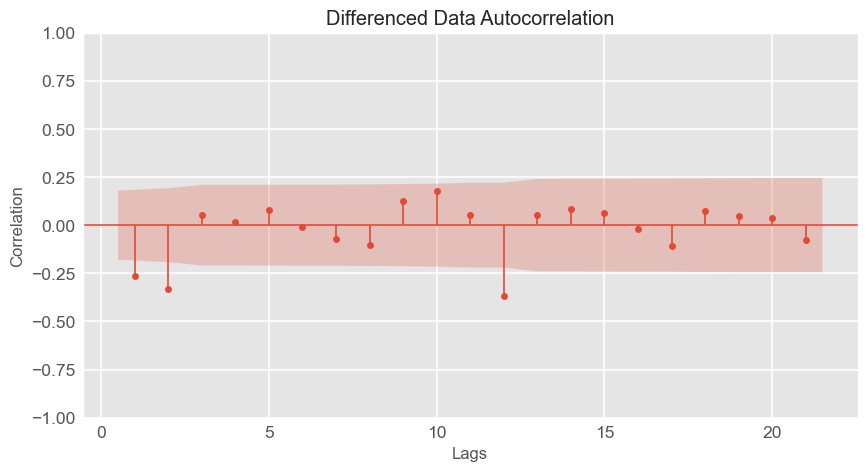

In [188]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_acf(rose_train_diff,
         zero=False,
         title='Differenced Data Autocorrelation',
         ax=axs)
axs.set_xlabel("Lags")
axs.set_ylabel("Correlation");
plt.savefig("images/Figure46.svg", bbox_inches="tight");

### Manual ARIMA(p, d, q) Model

In [189]:
rose_manual_ARIMA = ARIMA(
    rose_train['Rose'],
    order=(3, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

rose_results_manual_ARIMA = rose_manual_ARIMA.fit(method='innovations_mle')

print(rose_results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  132
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -622.692
Date:                Sun, 25 Sep 2022   AIC                           1257.385
Time:                        17:20:01   BIC                           1274.497
Sample:                    01-01-1980   HQIC                          1264.337
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7952      0.084     -9.459      0.000      -0.960      -0.630
ar.L2          0.0810      0.131      0.620      0.535      -0.175       0.337
ar.L3         -0.1237      0.102     -1.213      0.2

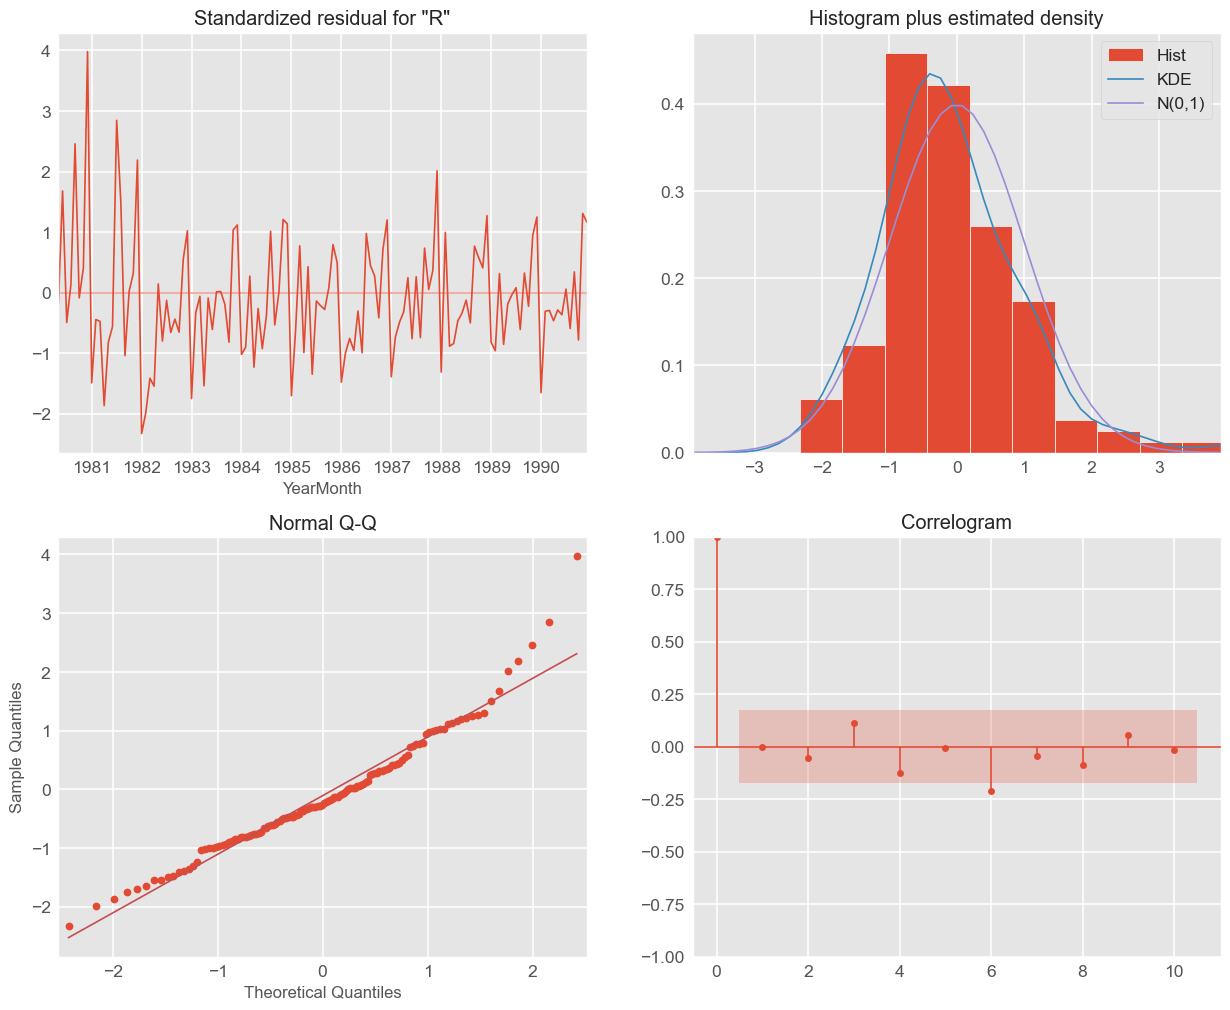

In [190]:
rose_results_manual_ARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure47.svg", bbox_inches="tight");

In [191]:
rose_predicted_manual_ARIMA = rose_results_manual_ARIMA.forecast(
    steps=len(rose_test))

In [192]:
rose_manual_ARIMA_rmse = mean_squared_error(rose_test["Rose"],
                                            rose_predicted_manual_ARIMA,
                                            squared=False)
print(
    f"RMSE for Manual ARIMA forecast model on Rose wine data: {rose_manual_ARIMA_rmse:.3f}"
)

RMSE for Manual ARIMA forecast model on Rose wine data: 36.342


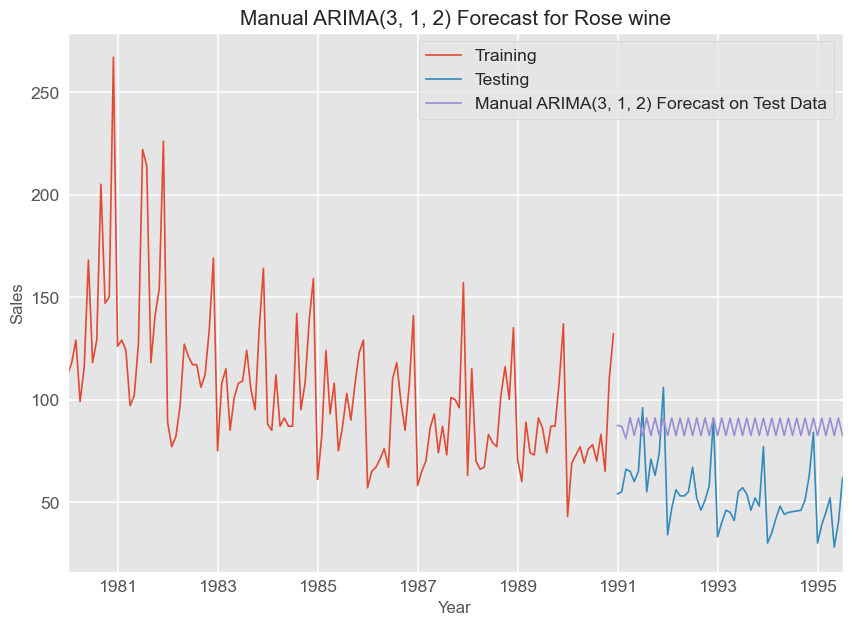

In [193]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_train.plot(y="Rose", ax=axs)
rose_test.plot(y="Rose", ax=axs)
rose_predicted_manual_ARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Manual ARIMA(3, 1, 2) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Manual ARIMA(3, 1, 2) Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure48.svg", bbox_inches="tight");

In [194]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_manual_ARIMA_rmse]},
                 index=["Manual ARIMA(3, 1, 2)"])
])

### Manual SARIMA(p, d, q)(P, D, Q, F) Model

In [195]:
rose_manual_SARIMA = sm.tsa.statespace.SARIMAX(
    rose_train['Rose'],
    order=(3, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

rose_results_manual_SARIMA = rose_manual_SARIMA.fit(disp=False, maxiter=10000)

print(rose_results_manual_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -446.285
Date:                              Sun, 25 Sep 2022   AIC                            906.571
Time:                                      17:20:19   BIC                            925.082
Sample:                                  01-01-1980   HQIC                           914.070
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8930      0.269      3.322      0.001       0.366       1.420
ar.L2         -0.21

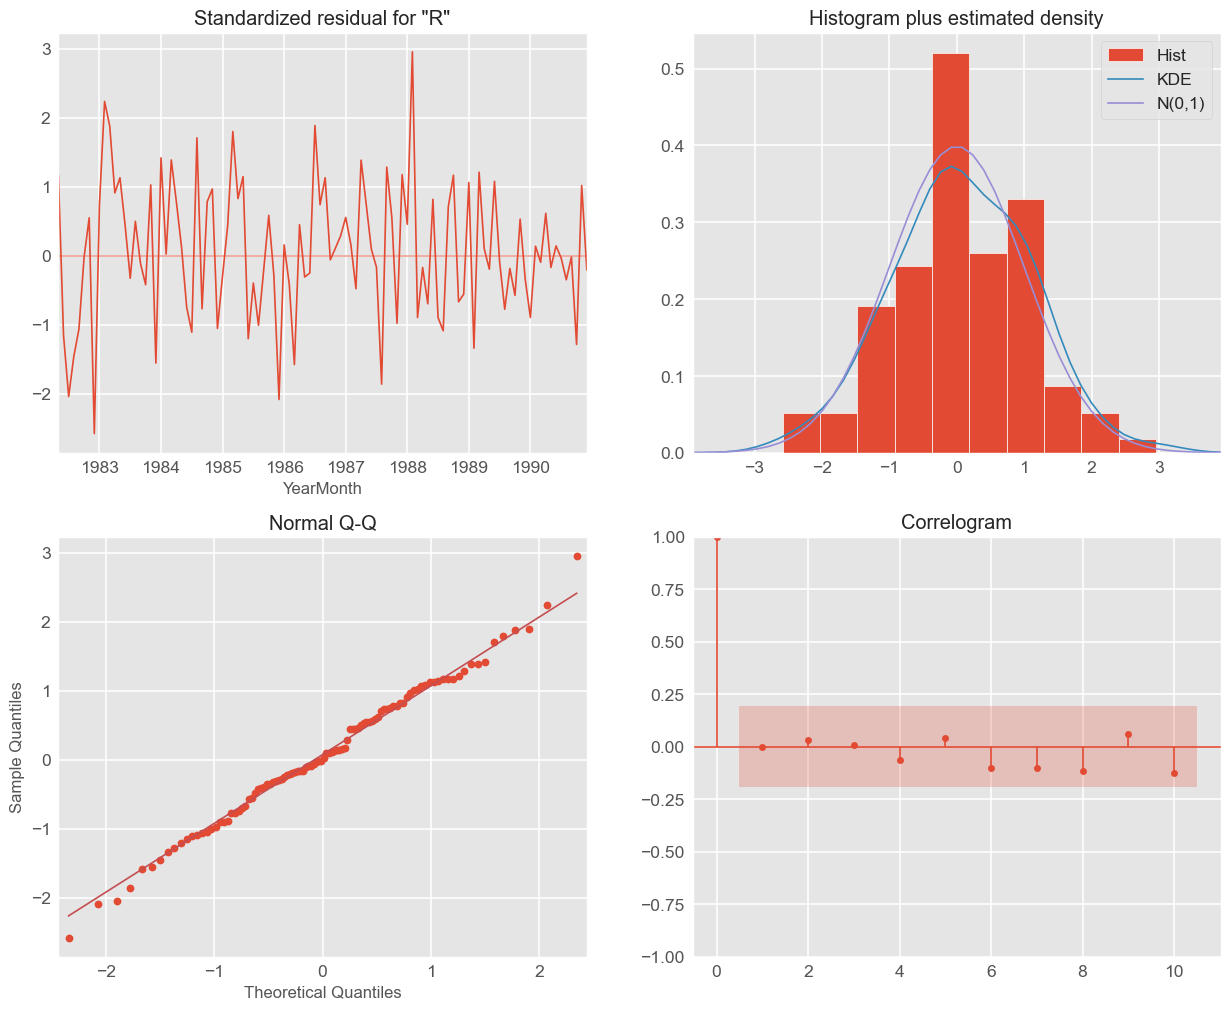

In [196]:
rose_results_manual_SARIMA.plot_diagnostics(figsize=(15, 12));
plt.savefig("images/Figure49.svg", bbox_inches="tight");

In [197]:
rose_predicted_manual_SARIMA = rose_results_manual_SARIMA.forecast(
    steps=len(rose_test))

In [198]:
rose_manual_SARIMA_rmse = mean_squared_error(rose_test.Rose,
                                             rose_predicted_manual_SARIMA,
                                             squared=False)
print(
    f"RMSE for Manual SARIMA forecast model on Rose wine data: {rose_manual_SARIMA_rmse:.3f}"
)

RMSE for Manual SARIMA forecast model on Rose wine data: 14.403


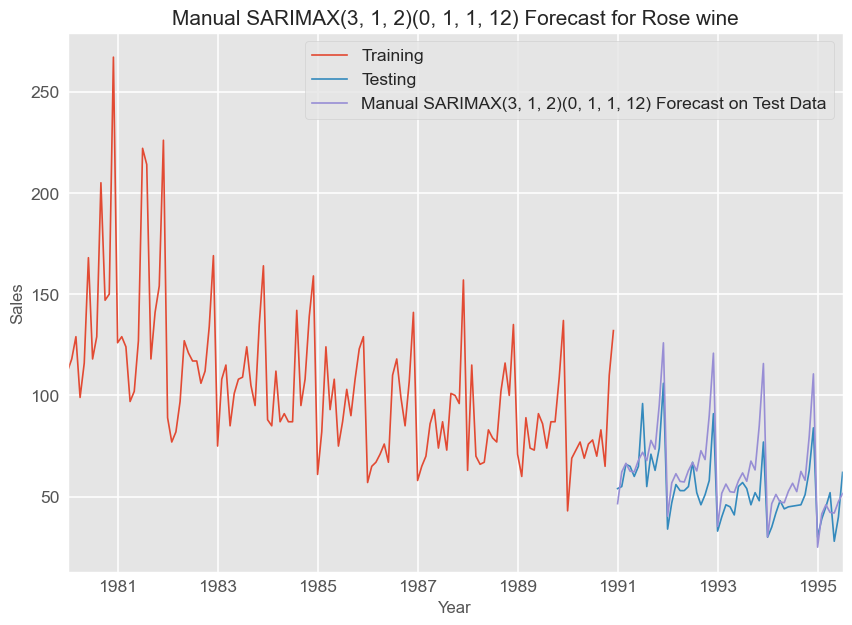

In [199]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_train.plot(y="Rose", ax=axs)
rose_test.plot(y="Rose", ax=axs)
rose_predicted_manual_SARIMA.plot(ax=axs)
axs.legend(["Training", "Testing", "Manual SARIMAX(3, 1, 2)(0, 1, 1, 12) Forecast on Test Data"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Manual SARIMAX(3, 1, 2)(0, 1, 1, 12) Forecast for Rose wine", fontdict={"fontsize": 15});
plt.savefig("images/Figure50.svg", bbox_inches="tight");

In [200]:
rose_results_df = pd.concat([
    rose_results_df,
    pd.DataFrame({"Test RMSE": [rose_manual_SARIMA_rmse]},
                 index=["Manual SARIMAX(3, 1, 2)(0, 1, 1, 12)"])
])

## 8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [201]:
rose_results_df.sort_values(by='Test RMSE', ascending=True)

Test RMSE
2 Point Moving Average                11.529278
Alpha=0.089, Beta=0, Gamma=0, TES     14.257478
Manual SARIMAX(3, 1, 2)(0, 1, 1, 12)  14.403168
Linear Regression                     15.268955
Alpha=0, Beta=0, DES                  15.269035
Auto SARIMAX(3, 1, 1)(3, 1, 1, 12)    16.823814
Auto ARIMA(2, 1, 3)                   36.239455
Manual ARIMA(3, 1, 2)                 36.342212
Alpha=0.09, SES                       36.796204
Simple Average                        53.460570
Naive Model                           79.718773

## 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

In [202]:
rose_df_2ma = rose_df.copy()

In [203]:
rose_df_2ma['Predictions'] = rose_df_2ma['Rose']
rose_df_2ma.drop("Rose", axis=1, inplace=True)

In [204]:
future_dates = pd.date_range(start='1995-08-01', periods=12, freq='MS')
rose_2ma_predictions_full = pd.DataFrame(index=future_dates)
rose_2ma_predictions_full['Predictions'] = np.nan

In [205]:
rose_df_2ma = pd.concat([rose_df_2ma, rose_2ma_predictions_full])
rose_df_2ma['Predictions'] = rose_df_2ma['Predictions'].rolling(2).mean()

In [206]:
rose_df_2ma.loc[future_dates, 'Predictions'] = rose_df_2ma['Predictions'][len(rose_df) - 1]
rose_2ma_predictions_full = rose_df_2ma.loc[future_dates, 'Predictions']
rose_2ma_predictions_full.head()

1995-08-01    51.0
1995-09-01    51.0
1995-10-01    51.0
1995-11-01    51.0
1995-12-01    51.0
Freq: MS, Name: Predictions, dtype: float64

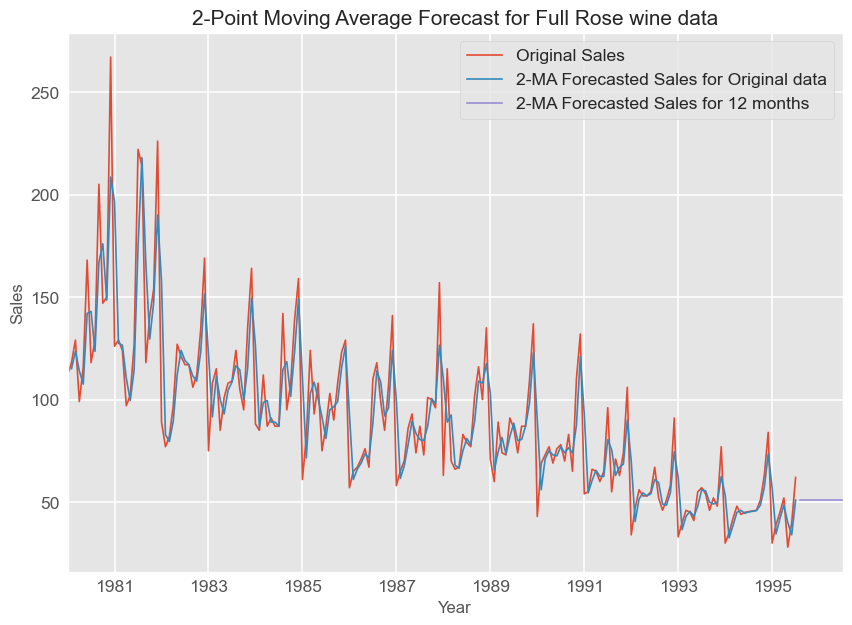

In [207]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
rose_df.plot(y="Rose", ax=axs)
rose_df_2ma.loc[rose_df.index, 'Predictions'].plot(y="Predictions", ax=axs)
rose_2ma_predictions_full.plot(y="Predictions", ax=axs)
axs.legend([
    "Original Sales",
    "2-MA Forecasted Sales for Original data",
    "2-MA Forecasted Sales for 12 months",
])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("2-Point Moving Average Forecast for Full Rose wine data",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure51.svg", bbox_inches="tight");

In [208]:
rose_TES_final_model = ExponentialSmoothing(rose_df.Rose,
                                            trend='additive',
                                            seasonal='additive',
                                            initialization_method='estimated')
rose_TES_final_autofit = rose_TES_final_model.fit(optimized=True, method='ls')

In [209]:
rose_TES_final_autofit.params

{'smoothing_level': 0.097,
 'smoothing_trend': 0.000,
 'smoothing_seasonal': 0.000,
 'damping_trend': nan,
 'initial_level': -8311426.530,
 'initial_trend': -0.538,
 'initial_seasons': array([8311544.241, 8311555.091, 8311563.191, 8311556.541, 8311560.454,
        8311566.491, 8311577.675, 8311577.608, 8311574.968, 8311574.239,
        8311589.377, 8311628.181]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [210]:
rose_TES_predictions_full = pd.DataFrame()
rose_TES_predictions_full['prediction'] = rose_TES_final_autofit.forecast(steps=12)
rose_TES_predictions_full['lower_ci'] = rose_TES_predictions_full['prediction'] - 1.96 * np.std(rose_TES_final_autofit.resid, ddof=1)
rose_TES_predictions_full['upper_ci'] = rose_TES_predictions_full['prediction'] + 1.96 * np.std(rose_TES_final_autofit.resid, ddof=1)
rose_TES_predictions_full.head()

prediction   lower_ci    upper_ci
1995-08-01   49.987545  15.282427   84.692663
1995-09-01   46.809842  12.104724   81.514960
1995-10-01   45.543055  10.837937   80.248174
1995-11-01   60.143595  25.438477   94.848713
1995-12-01   98.410024  63.704905  133.115142

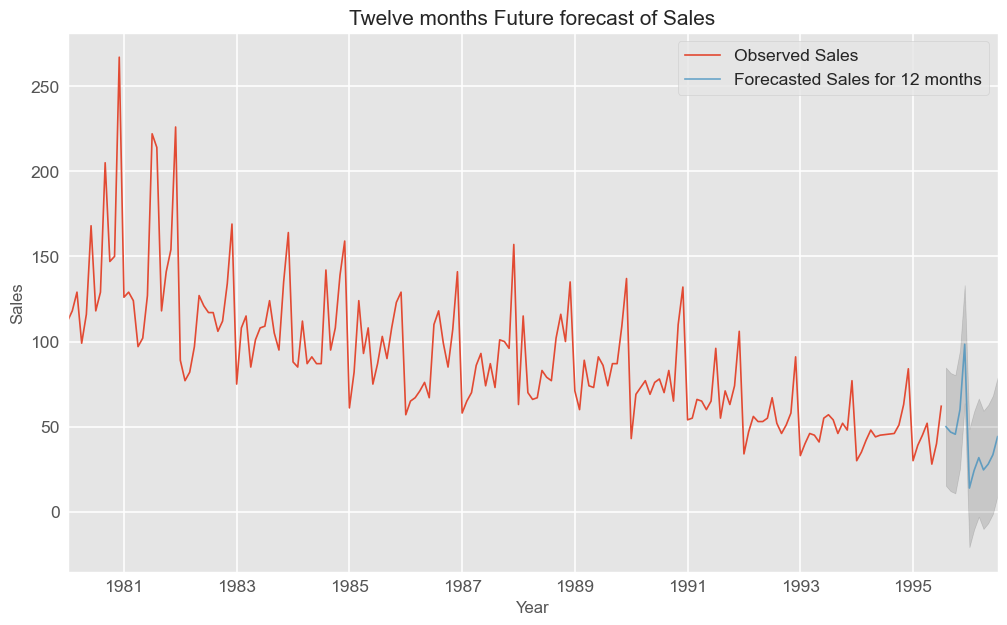

In [211]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
rose_df.plot(y="Rose", ax=axs)
rose_TES_predictions_full['prediction'].plot(ax=axs, alpha=0.7)
axs.fill_between(rose_TES_predictions_full.index,
                 rose_TES_predictions_full["lower_ci"],
                 rose_TES_predictions_full["upper_ci"],
                 color='k',
                 alpha=0.15)
axs.legend(["Observed Sales", "Forecasted Sales for 12 months"])
axs.set_xlabel("Year")
axs.set_ylabel("Sales")
axs.set_title("Twelve months Future forecast of Sales",
              fontdict={"fontsize": 15});
plt.savefig("images/Figure52.svg", bbox_inches="tight");